# RSM off-diagonal elements analysis 

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import pickle
from statsmodels.stats.multitest import multipletests

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as img
import matplotlib.colors as clrs
from matplotlib import colorbar
from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist

import nibabel as nib
import wbplot
from tqdm import tqdm

import plottools

In [2]:
projdir = '/home/ln275/f_mc1689_1/multitask_generalization/'
subProjDir = projdir + 'derivatives/RSM_ActFlow/'
helpfiles_dir = projdir + 'docs/files/'
figoutdir = projdir + 'docs/figures/vertexwiseFC/'
fcdir = projdir + 'derivatives/FC_new/'

In [3]:
subIDs=['02','03','06','08','10','12','14','18','20',
        '22','24','25','26','27','28','29','30','31']

onlyRestSubIdx = [ 0, 1, 3, 4, 6, 7, 8,10,11,
                  12,20,13,21,14,22,15,23,16] # Use when dealing with full subjects' data (n=24)

nSub = len(subIDs)
nParcels = 360
nVertices = 59412
nSessions = 2
nTaskCond = 96

glasserfilename = helpfiles_dir + 'Q1-Q6_RelatedParcellation210.LR.CorticalAreas_dil_Colors.32k_fs_RL.dlabel.nii'

glasser = np.squeeze(nib.load(glasserfilename).get_fdata())

networkdef = np.loadtxt(helpfiles_dir + 'cortex_parcel_network_assignments.txt')
networkNames = ['VIS1','VIS2','SMN','CON','DAN','LAN','FPN','AUD','DMN','PMULTI','VMM','ORA']
nNetw = 12

In [4]:
# Reading in the RSMs

# Observed:
with open(subProjDir + 'allsub_taskCond_RSM_activeVisual.pkl', 'rb') as f:
    allsub_taskCondRSM = pickle.load(f)
    
select_sub_taskCondRSM = allsub_taskCondRSM[onlyRestSubIdx,:,:,:] # rest data's available only for 18 sub
print('select_sub_taskCondRSM shape:',select_sub_taskCondRSM.shape)

# Actflow predicted:

with open(subProjDir + 'allsub_taskCond_RSM_activeVisual_actflowpred_PCR_CVoptimal.pkl', 'rb') as f1:
    allsub_predRSM = pickle.load(f1)
    
print('actflow-pred RSM shape:',allsub_predRSM.shape)

meansub_taskCondRSM = np.mean(select_sub_taskCondRSM,axis=0)
meansub_taskCondRSM_pred = np.mean(allsub_predRSM,axis=0)

select_sub_taskCondRSM shape: (18, 360, 96, 96)
actflow-pred RSM shape: (18, 360, 96, 96)


In [5]:
# Creating 1000 bootstrapped predicted null means from FC shuffling

# Reading in 100 permuted RSMs in each subject
with open(subProjDir + 'allsub_actflow_pred_RSM_connperm.pkl', 'rb') as f:
    RSM_connperm = pickle.load(f)
        
print(RSM_connperm.shape)

(18, 360, 96, 96, 100)


In [35]:
nPerm = 100
n_groupnull = 1000
RSM_connperm_groupmean = np.zeros((nParcels,nTaskCond,nTaskCond,n_groupnull))

with tqdm(total=n_groupnull, desc="Progress") as pbar:

    for groupnullIdx in range(n_groupnull):

        this_groupiter_connpermRSM = []

        for subIdx in range(nSub):

            this_groupiter_connpermRSM.append(RSM_connperm[subIdx,:,:,:,np.random.randint(0, nPerm)])

        RSM_connperm_groupmean[:,:,:,groupnullIdx] = np.mean(np.array(this_groupiter_connpermRSM),axis=0)
        
        pbar.update(1)

Progress: 100%|██████████| 1000/1000 [07:35<00:00,  2.19it/s]


(360, 1000)

In [36]:
RSM_connperm_groupmean.shape

(360, 96, 96, 1000)

In [37]:
with open(subProjDir + 'RSM_connperm_groupmean.pkl', 'wb') as f:
    pickle.dump(RSM_connperm_groupmean,f)

In [5]:
with open(subProjDir + 'RSM_connperm_groupmean.pkl', 'rb') as f:
    RSM_connperm_groupmean = pickle.load(f)

In [5]:
# Task indices to separate conditions within and between tasks

TaskIdx = np.array([1,1,2,2,3,3,3,3,3,3,3,3,7,7,4,4,5,5,7,7,8,8,8,2,2,9,9,9,9,11,11,
                    11,11,11,11,11,11,14,14,14,14,14,14,15,15,15,15,15,17,17,17,17,17,
                    17,17,17,17,17,17,17,18,18,18,18,18,18,19,19,19,19,19,19,19,19,19,
                    19,19,19,20,20,20,20,20,20,20,20,20,20,20,20,24,24,24,24,24,24])

unique_labels = np.unique(TaskIdx)
nTask = len(unique_labels)
print('Unique task IDs:',unique_labels)

tasknames = ['IAPS-Affective','Biological Motion','CPRO','IAPS-Emotional','Go-NoGo','Arithmetic','Word Prediction',
            'Theory of Mind','Stroop','Mental Rotation','Motor Sequence','Object n-back','Verbal n-back','Response Alt.',
             'Spatial Map','Visual Search']

Unique task IDs: [ 1  2  3  4  5  7  8  9 11 14 15 17 18 19 20 24]


In [6]:
# creating RSM indices for task conditions between same and different tasks, and for each task pair

same_task = TaskIdx[:, None] == TaskIdx[None, :]

same_task_idx = np.where(same_task)
diff_task_idx = np.where(~same_task)

# print('no.of same task cells:',same_task_idx[0].shape)
# print('no.of different task cells:',diff_task_idx[0].shape)

# Dictionary to store indices for each label combination
label_indices = {}
for label1 in unique_labels:
    for label2 in unique_labels:
        # Create a boolean mask for this label combination
        mask = (TaskIdx[:, None] == label1) & (TaskIdx[None, :] == label2)
        
        # Store the indices for this label combination
        label_indices[(label1, label2)] = np.where(mask)

In [7]:
# Running significance test across subjects:

taskCondRSM_fisher = np.arctanh(select_sub_taskCondRSM)
taskCondRSM_fisher_pred = np.arctanh(allsub_predRSM)

allroi_t,allroi_p = stats.ttest_1samp(taskCondRSM_fisher, popmean=0, axis=0)
allroi_t_pred,allroi_p_pred = stats.ttest_1samp(taskCondRSM_fisher_pred, popmean=0, axis=0)

signif_RSMcells_byroi = np.zeros((nParcels,nTaskCond,nTaskCond))

meansubRSM_survived = np.zeros((nParcels,nTaskCond,nTaskCond))
this_pair_meanSim_pos = np.zeros((nParcels,nTask,nTask))

for roiIdx in range(nParcels):

    thisroi_pval = allroi_p[roiIdx,:,:].flatten()
    rejected, corrected_p_values, _, _ = multipletests(thisroi_pval, method='fdr_bh')
    rejected_reshaped = rejected.reshape((96,96))

    signif_RSMcells_byroi[roiIdx,:,:] = rejected_reshaped
    
    thisROI_RSM_survived = np.where(rejected_reshaped==True,meansub_taskCondRSM[roiIdx],np.nan)
    meansubRSM_survived[roiIdx,:,:] = thisROI_RSM_survived

    # for each task combination

    for taskA in range(nTask):
        for taskB in range(nTask):
            this_pair_idx = label_indices.get((unique_labels[taskA],unique_labels[taskB]))
            # this_pair_signif_prop[roiIdx,taskA,taskB] = np.sum(rejected_reshaped[this_pair_idx])/this_pair_idx[0].shape[0]
            this_pair_RSMslice = thisROI_RSM_survived[this_pair_idx]
            this_pair_meanSim_pos[roiIdx,taskA,taskB] = np.mean(this_pair_RSMslice[this_pair_RSMslice>0])

/home/ln275/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ln275/.local/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [8]:
# meansimpos and meansimneg by subject for significance test later

allsub_this_pair_meanSim_pos = np.zeros((nSub,nParcels,nTask,nTask))
allsub_this_pair_meanSim_pos_pred = np.zeros((nSub,nParcels,nTask,nTask))

for roiIdx in range(nParcels):

    rejected_reshaped = signif_RSMcells_byroi[roiIdx,:,:]
    
    for subIdx in range(nSub):
    
        thisROI_RSM_survived = np.where(rejected_reshaped==True,select_sub_taskCondRSM[subIdx,roiIdx],np.nan)
        thisROI_RSM_survived_pred = np.where(rejected_reshaped==True,allsub_predRSM[subIdx,roiIdx],np.nan)

        # for each task combination

        for taskA in range(nTask):
            for taskB in range(nTask):
                this_pair_idx = label_indices.get((unique_labels[taskA],unique_labels[taskB]))

                this_pair_RSMslice = thisROI_RSM_survived[this_pair_idx]
                allsub_this_pair_meanSim_pos[subIdx,roiIdx,taskA,taskB] = np.mean(this_pair_RSMslice[this_pair_RSMslice>0])

                this_pair_RSMslice_pred = thisROI_RSM_survived_pred[this_pair_idx]
                allsub_this_pair_meanSim_pos_pred[subIdx,roiIdx,taskA,taskB] = np.mean(this_pair_RSMslice_pred[this_pair_RSMslice_pred>0])

In [9]:
# For predicted RSMs

meansubRSM_survived_pred = np.zeros((nParcels,nTaskCond,nTaskCond))
this_pair_signif_prop_pred = np.zeros((nParcels,nTask,nTask))
this_pair_meanSim_pos_pred = np.zeros((nParcels,nTask,nTask))
this_pair_meanSim_neg_pred = np.zeros((nParcels,nTask,nTask))

for roiIdx in range(nParcels):
    
    thisroi_pval = allroi_p_pred[roiIdx,:,:].flatten()
    rejected, corrected_p_values, _, _ = multipletests(thisroi_pval, method='fdr_bh')
    rejected_reshaped = rejected.reshape((96,96))

    thisROI_RSM_survived = np.where(rejected_reshaped==True,meansub_taskCondRSM_pred[roiIdx],np.nan)
    meansubRSM_survived_pred[roiIdx,:,:] = thisROI_RSM_survived

    # within_task_signif_prop[roiIdx] = np.sum(rejected_reshaped[same_task_idx])/same_task_idx[0].shape[0]
    # cross_task_signif_prop[roiIdx] = np.sum(rejected_reshaped[diff_task_idx])/diff_task_idx[0].shape[0]

    # for each task combination

    for taskA in range(nTask):
        for taskB in range(nTask):
            this_pair_idx = label_indices.get((unique_labels[taskA],unique_labels[taskB]))

            this_pair_signif_prop_pred[roiIdx,taskA,taskB] = np.sum(rejected_reshaped[this_pair_idx])/this_pair_idx[0].shape[0]

            this_pair_RSMslice = thisROI_RSM_survived[this_pair_idx]
            this_pair_meanSim_pos_pred[roiIdx,taskA,taskB] = np.mean(this_pair_RSMslice[this_pair_RSMslice>0])
            this_pair_meanSim_neg_pred[roiIdx,taskA,taskB] = np.mean(this_pair_RSMslice[this_pair_RSMslice<0])

In [ ]:
# For predicted groupnullRSMs

meansubRSM_survived_pred_groupnull = np.zeros((nParcels,nTaskCond,nTaskCond,n_groupnull))
this_pair_meanSim_pos_pred_groupnull = np.zeros((nParcels,nTask,nTask,n_groupnull))
this_pair_meanSim_neg_pred_groupnull = np.zeros((nParcels,nTask,nTask,n_groupnull))

with tqdm(total=nParcels, desc="Progress") as pbar:

    for roiIdx in range(nParcels):

        thisroi_pval = allroi_p_pred[roiIdx,:,:].flatten()
        rejected, corrected_p_values, _, _ = multipletests(thisroi_pval, method='fdr_bh')
        rejected_reshaped = rejected.reshape((96,96))

        for groupnullIdx in range(n_groupnull):

            thisROI_groupnullRSM_survived = np.where(rejected_reshaped==True,RSM_connperm_groupmean[roiIdx,:,:,groupnullIdx],np.nan)
            meansubRSM_survived_pred_groupnull[roiIdx,:,:,groupnullIdx] = thisROI_groupnullRSM_survived

            # for each task combination

            for taskA in range(nTask):
                for taskB in range(nTask):
                    this_pair_idx = label_indices.get((unique_labels[taskA],unique_labels[taskB]))

                    this_pair_RSMslice = thisROI_groupnullRSM_survived[this_pair_idx]
                    this_pair_meanSim_pos_pred_groupnull[roiIdx,taskA,taskB,groupnullIdx] = np.mean(this_pair_RSMslice[this_pair_RSMslice>0])
                    this_pair_meanSim_neg_pred_groupnull[roiIdx,taskA,taskB,groupnullIdx] = np.mean(this_pair_RSMslice[this_pair_RSMslice<0])
                    
        pbar.update(1)

Progress:   0%|          | 0/360 [00:00<?, ?it/s]/home/ln275/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ln275/.local/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
Progress:   8%|▊         | 27/360 [02:27<30:41,  5.53s/it]

In [43]:
with open(subProjDir + 'RSM_connperm_groupmean_predMeanSim_pos_neg.pkl', 'wb') as f:
    pickle.dump(this_pair_meanSim_pos_pred_groupnull,f)
    pickle.dump(this_pair_meanSim_neg_pred_groupnull,f)

In [12]:
# Reading back

with open(subProjDir + 'RSM_connperm_groupmean_predMeanSim_pos_neg.pkl', 'rb') as f:
    this_pair_meanSim_pos_pred_groupnull = pickle.load(f)
    this_pair_meanSim_neg_pred_groupnull = pickle.load(f)

In [13]:
this_pair_meanSim_pos_nanzeroed = np.where(np.isnan(this_pair_meanSim_pos),0,this_pair_meanSim_pos)
# this_pair_meanSim_neg_nanzeroed = np.where(np.isnan(this_pair_meanSim_neg),0,this_pair_meanSim_neg)

In [14]:
allsub_this_pair_meanSim_pos_nanzeroed = np.where(np.isnan(allsub_this_pair_meanSim_pos),0,allsub_this_pair_meanSim_pos)
allsub_this_pair_meanSim_pos_pred_nanzeroed = np.where(np.isnan(allsub_this_pair_meanSim_pos_pred),0,allsub_this_pair_meanSim_pos_pred)

In [15]:
this_pair_meanSim_pos_pred_nanzeroed = np.where(np.isnan(this_pair_meanSim_pos_pred),0,this_pair_meanSim_pos_pred)
# this_pair_meanSim_neg_pred_nanzeroed = np.where(np.isnan(this_pair_meanSim_neg_pred),0,this_pair_meanSim_neg_pred)

In [16]:
this_pair_meanSim_pos_pred_groupnull_nanzeroed = np.where(np.isnan(this_pair_meanSim_pos_pred_groupnull),0,this_pair_meanSim_pos_pred_groupnull)
this_pair_meanSim_neg_pred_groupnull_nanzeroed = np.where(np.isnan(this_pair_meanSim_neg_pred_groupnull),0,this_pair_meanSim_neg_pred_groupnull)

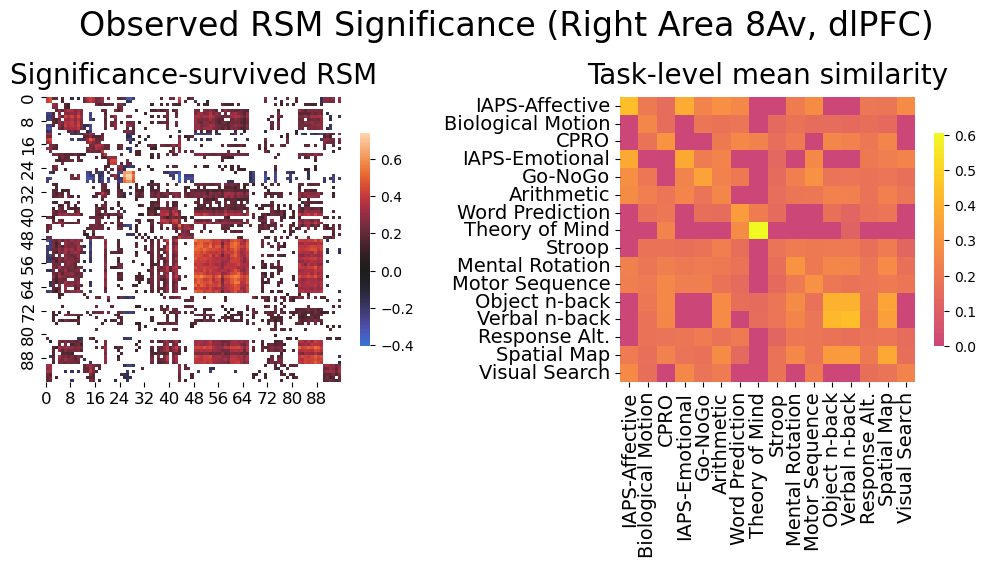

In [39]:
roiIdx = 246

fig,ax = plt.subplots(1, 2, figsize=(10,5.75))
ax1, ax2 = ax.flatten()

abs_max = np.max([np.nanmax(this_pair_meanSim_pos[roiIdx,:,:]),np.abs(np.nanmin(this_pair_meanSim_neg[roiIdx,:,:]))])

# Meansub RSM survived
sns.heatmap(meansubRSM_survived[roiIdx,:,:],center=0,ax=ax1,cbar_kws={"shrink": 0.75})
ax1.set_title('Significance-survived RSM', fontsize=20, pad=10)
ticks = np.arange(0, 96, 8)
tick_labels = [str(t) for t in ticks]

ax1.set_xticks(ticks)
ax1.set_yticks(ticks)
ax1.set_xticklabels(tick_labels,fontsize=12,rotation=0)
ax1.set_yticklabels(tick_labels,fontsize=12)

# # Proportion significant
# sns.heatmap(this_pair_signif_prop[roiIdx,:,:], xticklabels=tasknames, yticklabels=tasknames,center=0,ax=ax2,cmap='viridis',cbar_kws={"shrink": 0.75})
# ax2.set_xticklabels(ax2.get_xticklabels(),fontsize=8)
# ax2.set_yticklabels(ax2.get_yticklabels(),fontsize=8)
# ax2.set_title('Prop. signif. task cond. combinations', fontsize=10)

# Mean similarity (positive)
sns.heatmap(this_pair_meanSim_pos_nanzeroed[roiIdx,:,:], xticklabels=tasknames, yticklabels=tasknames,center=0,ax=ax2,vmin=0,vmax=abs_max,cmap='plasma',cbar_kws={"shrink": 0.75})
ax2.set_xticklabels(ax2.get_xticklabels(),fontsize=14)
ax2.set_yticklabels(ax2.get_yticklabels(),fontsize=14)
ax2.set_title('Task-level mean similarity', fontsize=20, pad=10)

# # Mean similarity (negative)
# sns.heatmap(this_pair_meanSim_neg_nanzeroed[roiIdx,:,:], xticklabels=tasknames, yticklabels=tasknames,center=0,ax=ax4,vmin=-abs_max,vmax=0,cmap='Blues_r',cbar_kws={"shrink": 0.75})
# ax4.set_xticklabels(ax4.get_xticklabels(),fontsize=8)
# ax4.set_yticklabels(ax4.get_yticklabels(),fontsize=8)
# ax4.set_title('Mean similarity (negative, significant)', fontsize=10)

plt.suptitle("Observed RSM Significance (Right Area 8Av, dlPFC)", fontsize=24)

plt.subplots_adjust(wspace=0.5)

plt.tight_layout()
plt.savefig(figoutdir + 'RSM_survived_example.pdf',transparent = True)
# Display the plots
plt.show()

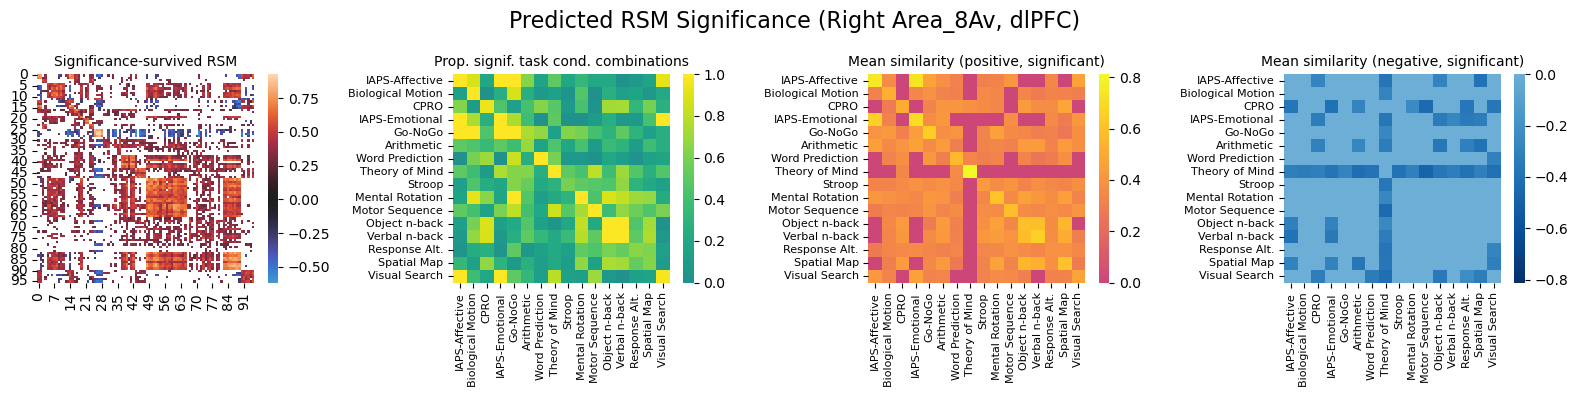

In [56]:
roiIdx = 246

fig,ax = plt.subplots(1, 4, figsize=(16,4))
ax1, ax2, ax3, ax4 = ax.flatten()

abs_max = np.max([np.nanmax(this_pair_meanSim_pos_pred[roiIdx,:,:]),np.abs(np.nanmin(this_pair_meanSim_neg_pred[roiIdx,:,:]))])

# Meansub RSM survived
sns.heatmap(meansubRSM_survived_pred[roiIdx,:,:],center=0,ax=ax1)
ax1.set_title('Significance-survived RSM', fontsize=10)

# Proportion significant
sns.heatmap(this_pair_signif_prop_pred[roiIdx,:,:], xticklabels=tasknames, yticklabels=tasknames,center=0,ax=ax2,cmap='viridis')
ax2.set_xticklabels(ax2.get_xticklabels(),fontsize=8)
ax2.set_yticklabels(ax2.get_yticklabels(),fontsize=8)
ax2.set_title('Prop. signif. task cond. combinations', fontsize=10)

# Mean similarity (positive)
sns.heatmap(this_pair_meanSim_pos_pred_nanzeroed[roiIdx,:,:], xticklabels=tasknames, yticklabels=tasknames,center=0,ax=ax3,vmin=0,vmax=abs_max,cmap='plasma')
ax3.set_xticklabels(ax3.get_xticklabels(),fontsize=8)
ax3.set_yticklabels(ax3.get_yticklabels(),fontsize=8)
ax3.set_title('Mean similarity (positive, significant)', fontsize=10)

# Mean similarity (negative)
sns.heatmap(this_pair_meanSim_neg_pred_nanzeroed[roiIdx,:,:], xticklabels=tasknames, yticklabels=tasknames,center=0,ax=ax4,vmin=-abs_max,vmax=0,cmap='Blues_r')
ax4.set_xticklabels(ax4.get_xticklabels(),fontsize=8)
ax4.set_yticklabels(ax4.get_yticklabels(),fontsize=8)
ax4.set_title('Mean similarity (negative, significant)', fontsize=10)

plt.suptitle("Predicted RSM Significance (Right Area_8Av, dlPFC)", fontsize=16)

plt.subplots_adjust(wspace=0.5, hspace=0.7)

plt.tight_layout()
plt.savefig(figoutdir + 'RSM_survived_pred_example.pdf',transparent = True)
# Display the plots
plt.show()

In [16]:
def get_tasklevel_cosSim_bynet(obs_mat,pred_mat):

    withintask_cosSim = np.zeros(nNetw)
    crosstask_cosSim = np.zeros(nNetw)

    for netwIdx in range(nNetw):

        obs = obs_mat[netwIdx,:,:]
        pred = pred_mat[netwIdx,:,:]
        
        # Get non-diagonal indices
        diag_indices = np.diag_indices_from(obs)

        # Create a mask that is True everywhere except the diagonal
        mask = np.ones(obs.shape, dtype=bool)
        mask[diag_indices] = False

        # Cosine similarity between obs and pred, separately within and across tasks

        obs_withintask = obs[diag_indices]
        obs_withintask_normed = obs_withintask / np.linalg.norm(obs_withintask)

        pred_withintask = pred[diag_indices]
        pred_withintask_normed = pred_withintask / np.linalg.norm(pred_withintask)

        obs_crosstask = obs[mask]
        obs_crosstask_normed = obs_crosstask / np.linalg.norm(obs_crosstask)

        pred_crosstask = pred[mask]
        pred_crosstask_normed = pred_crosstask / np.linalg.norm(pred_crosstask)

        withintask_cosSim[netwIdx] = np.dot(obs_withintask_normed, pred_withintask_normed.T)
        crosstask_cosSim[netwIdx] = np.dot(obs_crosstask_normed, pred_crosstask_normed.T)
        
    return withintask_cosSim, crosstask_cosSim

In [17]:
def get_tasklevel_cosSim(obs_mat,pred_mat):

    obs = obs_mat
    pred = pred_mat

    # Get non-diagonal indices
    diag_indices = np.diag_indices_from(obs)

    # Create a mask that is True everywhere except the diagonal
    mask = np.ones(obs.shape, dtype=bool)
    mask[diag_indices] = False

    # Cosine similarity between obs and pred, separately within and across tasks

    obs_withintask = obs[diag_indices]
    obs_withintask_normed = obs_withintask / np.linalg.norm(obs_withintask)

    pred_withintask = pred[diag_indices]
    pred_withintask_normed = pred_withintask / np.linalg.norm(pred_withintask)

    obs_crosstask = obs[mask]
    obs_crosstask_normed = obs_crosstask / np.linalg.norm(obs_crosstask)

    pred_crosstask = pred[mask]
    pred_crosstask_normed = pred_crosstask / np.linalg.norm(pred_crosstask)

    withintask_cosSim = np.dot(obs_withintask_normed, pred_withintask_normed.T)
    crosstask_cosSim = np.dot(obs_crosstask_normed, pred_crosstask_normed.T)
        
    return withintask_cosSim, crosstask_cosSim

In [19]:
# Cosine similarity by region

meanSimPos_cosSim_wt_byregion = np.zeros(nParcels)
meanSimPos_cosSim_ct_byregion = np.zeros(nParcels)
# meanSimNeg_cosSim_wt_byregion = np.zeros(nParcels)
# meanSimNeg_cosSim_ct_byregion = np.zeros(nParcels)

for roiIdx in range(nParcels):

    meanSimPos_cosSim_wt_byregion[roiIdx], meanSimPos_cosSim_ct_byregion[roiIdx] = get_tasklevel_cosSim(obs_mat=this_pair_meanSim_pos_nanzeroed[roiIdx,:,:],
                                                               pred_mat=this_pair_meanSim_pos_pred_nanzeroed[roiIdx,:,:])

    # meanSimNeg_cosSim_wt_byregion[roiIdx], meanSimNeg_cosSim_ct_byregion[roiIdx] = get_tasklevel_cosSim(obs_mat=this_pair_meanSim_neg_nanzeroed[roiIdx,:,:],
                                                               # pred_mat=this_pair_meanSim_neg_pred_nanzeroed[roiIdx,:,:])

/tmp/ipykernel_36758/459070345.py:16: RuntimeWarning: invalid value encountered in true_divide
  obs_withintask_normed = obs_withintask / np.linalg.norm(obs_withintask)
/tmp/ipykernel_36758/459070345.py:22: RuntimeWarning: invalid value encountered in true_divide
  obs_crosstask_normed = obs_crosstask / np.linalg.norm(obs_crosstask)


In [30]:
# Cosine similarity by region (null)

n_groupnull = 1000

meanSimPos_cosSim_wt_byregion_connperm = np.zeros((nParcels,n_groupnull))
meanSimPos_cosSim_ct_byregion_connperm = np.zeros((nParcels,n_groupnull))
meanSimNeg_cosSim_wt_byregion_connperm = np.zeros((nParcels,n_groupnull))
meanSimNeg_cosSim_ct_byregion_connperm = np.zeros((nParcels,n_groupnull))

for roiIdx in range(nParcels):
    
    for groupnullIdx in range(n_groupnull):

        meanSimPos_cosSim_wt_byregion_connperm[roiIdx,groupnullIdx], meanSimPos_cosSim_ct_byregion_connperm[roiIdx,groupnullIdx] = get_tasklevel_cosSim(obs_mat=this_pair_meanSim_pos_nanzeroed[roiIdx,:,:],
                                                                   pred_mat=this_pair_meanSim_pos_pred_groupnull_nanzeroed[roiIdx,:,:,groupnullIdx])

        meanSimNeg_cosSim_wt_byregion_connperm[roiIdx,groupnullIdx], meanSimNeg_cosSim_ct_byregion_connperm[roiIdx,groupnullIdx] = get_tasklevel_cosSim(obs_mat=this_pair_meanSim_neg_nanzeroed[roiIdx,:,:],
                                                                   pred_mat=this_pair_meanSim_neg_pred_groupnull_nanzeroed[roiIdx,:,:,groupnullIdx])

/tmp/ipykernel_40449/459070345.py:16: RuntimeWarning: invalid value encountered in true_divide
  obs_withintask_normed = obs_withintask / np.linalg.norm(obs_withintask)
/tmp/ipykernel_40449/459070345.py:22: RuntimeWarning: invalid value encountered in true_divide
  obs_crosstask_normed = obs_crosstask / np.linalg.norm(obs_crosstask)


In [20]:
# Turn nans to zeros for brain plot

meanSimPos_cosSim_ct_byregion_nanzeroed = np.where(np.isnan(meanSimPos_cosSim_ct_byregion),0,meanSimPos_cosSim_ct_byregion)
# meanSimNeg_cosSim_ct_byregion_nanzeroed = np.where(np.isnan(meanSimNeg_cosSim_ct_byregion),0,meanSimNeg_cosSim_ct_byregion)

meanSimPos_cosSim_wt_byregion_nanzeroed = np.where(np.isnan(meanSimPos_cosSim_wt_byregion),0,meanSimPos_cosSim_wt_byregion)
# meanSimNeg_cosSim_wt_byregion_nanzeroed = np.where(np.isnan(meanSimNeg_cosSim_wt_byregion),0,meanSimNeg_cosSim_wt_byregion)

In [26]:
meanSimPos_cosSim_ct_byregion_connperm.shape

(360, 1000)

In [32]:
# Filter based on FC shuffling significance

# Positive cross-task similarity
pos_ct_thr95 = np.percentile(meanSimPos_cosSim_ct_byregion_connperm, 95, axis=1)
pos_ct_survived = meanSimPos_cosSim_ct_byregion_nanzeroed > pos_ct_thr95
meanSimPos_cosSim_ct_byregion_nanzeroed_survived = meanSimPos_cosSim_ct_byregion_nanzeroed * pos_ct_survived

print('pos_ct_survived #regions:',np.sum(pos_ct_survived))
print('range:',np.min(meanSimPos_cosSim_ct_byregion_nanzeroed_survived[pos_ct_survived]),np.max(meanSimPos_cosSim_ct_byregion_nanzeroed_survived))

# Negative cross-task similarity
neg_ct_thr95 = np.percentile(meanSimNeg_cosSim_ct_byregion_connperm, 95, axis=1)
neg_ct_survived = meanSimNeg_cosSim_ct_byregion_nanzeroed > neg_ct_thr95
meanSimNeg_cosSim_ct_byregion_nanzeroed_survived = meanSimNeg_cosSim_ct_byregion_nanzeroed * neg_ct_survived

print('neg_ct_survived #regions:',np.sum(neg_ct_survived))
print('range:',np.min(meanSimNeg_cosSim_ct_byregion_nanzeroed_survived[neg_ct_survived]),np.max(meanSimNeg_cosSim_ct_byregion_nanzeroed_survived))

# Positive within-task similarity
pos_wt_thr95 = np.percentile(meanSimPos_cosSim_wt_byregion_connperm, 95, axis=1)
pos_wt_survived = meanSimPos_cosSim_wt_byregion_nanzeroed > pos_wt_thr95
meanSimPos_cosSim_wt_byregion_nanzeroed_survived = meanSimPos_cosSim_wt_byregion_nanzeroed * pos_wt_survived

print('pos_wt_survived #regions:',np.sum(pos_wt_survived))
print('range:',np.min(meanSimPos_cosSim_wt_byregion_nanzeroed_survived[pos_wt_survived]),np.max(meanSimPos_cosSim_wt_byregion_nanzeroed_survived))

# Negative within-task similarity
neg_wt_thr95 = np.percentile(meanSimNeg_cosSim_wt_byregion_connperm, 95, axis=1)
neg_wt_survived = meanSimNeg_cosSim_wt_byregion_nanzeroed > neg_wt_thr95
meanSimNeg_cosSim_wt_byregion_nanzeroed_survived = meanSimNeg_cosSim_wt_byregion_nanzeroed * neg_wt_survived

print('neg_wt_survived #regions:',np.sum(neg_wt_survived))
print('range:',np.min(meanSimNeg_cosSim_wt_byregion_nanzeroed_survived[neg_wt_survived]),np.max(meanSimNeg_cosSim_wt_byregion_nanzeroed_survived))

pos_ct_survived #regions: 355
range: 0.13051602675059396 0.99465648759131
neg_ct_survived #regions: 320
range: 0.15383613862145007 0.9763597277345447
pos_wt_survived #regions: 357
range: 0.32344517181958815 0.9966785168386315
neg_wt_survived #regions: 12
range: 0.9162229634259533 1.0


pixdim[1,2,3] should be non-zero; setting 0 dims to 1

Info: Time to read /tmp/HumanCorticalParcellations/S1200.L.flat.32k_fs_LR.surf.gii was 0.045892 seconds.


Info: Time to read /tmp/HumanCorticalParcellations/S1200.L.inflated_MSMAll.32k_fs_LR.surf.gii was 0.019963 seconds.


Info: Time to read /tmp/HumanCorticalParcellations/S1200.L.midthickness_MSMAll.32k_fs_LR.surf.gii was 0.029415 seconds.


Info: Time to read /tmp/HumanCorticalParcellations/S1200.L.very_inflated_MSMAll.32k_fs_LR.surf.gii was 0.017349 seconds.


Info: Time to read /tmp/HumanCorticalParcellations/S1200.R.flat.32k_fs_LR.surf.gii was 0.044241 seconds.


Info: Time to read /tmp/HumanCorticalParcellations/S1200.R.inflated_MSMAll.32k_fs_LR.surf.gii was 0.01849 seconds.


Info: Time to read /tmp/HumanCorticalParcellations/S1200.R.midthickness_MSMAll.32k_fs_LR.surf.gii was 0.028153 seconds.


Info: Time to read /tmp/HumanCorticalParcellations/S1200.R.very_inflated_MSMAll.32k_fs_LR.surf.gii was 0.017257 seconds.


Info: 

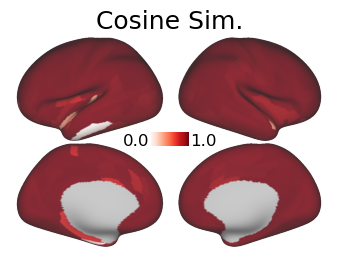

In [82]:
# Plotting brain plots: positive within-task similarity

file_out = figoutdir + "RSM_MeanSignificantPosSim_cosSim_wActFlowPred_withintask.png"
inputdata = meanSimPos_cosSim_wt_byregion_nanzeroed_survived

#flip hemispheres, since CAB-NP is ordered left-to-right, while wbplot uses right-to-left
inputdata_flipped=np.zeros(np.shape(inputdata))
inputdata_flipped[0:180]=inputdata[180:360]
inputdata_flipped[180:360]=inputdata[0:180]

#Set to all reds if no negative values
# if min(inputdata) >= 0:
#     colormap='Reds'
# else:
#     colormap='seismic'

vmin, vmax = np.min(inputdata), np.max(inputdata)

colormap='Reds'
wbplot.pscalar(
        file_out=file_out,
        pscalars=inputdata_flipped,
        vrange = (vmin,vmax),
        cmap=colormap,
        transparent=True)

plt.figure(figsize=(3.5,3))
ax = plt.subplot(111)
im = img.imread(file_out) 
plt.imshow(im)
plt.axis('off')
plt.title('Cosine Sim.',fontsize=18)

# vmin, vmax = -2, 2
cnorm = clrs.Normalize(vmin=vmin, vmax=vmax)  # only important for tick placing
cmap = plt.get_cmap('Reds')
cax = ax.inset_axes([0.44, 0.48, 0.12, 0.07])
cbar = colorbar.ColorbarBase(
    cax, cmap=cmap, norm=cnorm, orientation='horizontal')
#cbar.set_ticks([-2, 2])  # don't need to do this since we're going to hide them
cax.get_xaxis().set_tick_params(length=0, pad=-2)
cbar.set_ticklabels([])
cbar.outline.set_visible(False)
cax.text(-0.025, 0.4, str(round(vmin,2)), ha='right', va='center', transform=cax.transAxes,
         fontsize=12);
cax.text(1.025, 0.4, str(round(vmax,2)), ha='left', va='center', transform=cax.transAxes,
         fontsize=12);
plt.tight_layout()
plt.savefig(figoutdir + 'RSM_MeanSignificantPosSim_cosSim_wActFlowPred_withintask.pdf',transparent=True)

pixdim[1,2,3] should be non-zero; setting 0 dims to 1

Info: Time to read /tmp/HumanCorticalParcellations/S1200.L.flat.32k_fs_LR.surf.gii was 0.047513 seconds.


Info: Time to read /tmp/HumanCorticalParcellations/S1200.L.inflated_MSMAll.32k_fs_LR.surf.gii was 0.018563 seconds.


Info: Time to read /tmp/HumanCorticalParcellations/S1200.L.midthickness_MSMAll.32k_fs_LR.surf.gii was 0.028644 seconds.


Info: Time to read /tmp/HumanCorticalParcellations/S1200.L.very_inflated_MSMAll.32k_fs_LR.surf.gii was 0.017458 seconds.


Info: Time to read /tmp/HumanCorticalParcellations/S1200.R.flat.32k_fs_LR.surf.gii was 0.046046 seconds.


Info: Time to read /tmp/HumanCorticalParcellations/S1200.R.inflated_MSMAll.32k_fs_LR.surf.gii was 0.018345 seconds.


Info: Time to read /tmp/HumanCorticalParcellations/S1200.R.midthickness_MSMAll.32k_fs_LR.surf.gii was 0.029416 seconds.


Info: Time to read /tmp/HumanCorticalParcellations/S1200.R.very_inflated_MSMAll.32k_fs_LR.surf.gii was 0.017302 seconds.


Info:

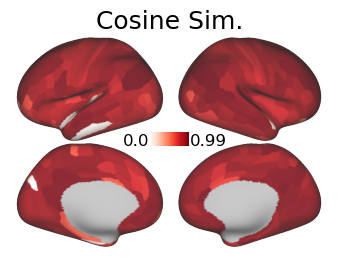

In [79]:
# Plotting brain plots: positive cross-task similarity

file_out = figoutdir + "RSM_MeanSignificantPosSim_cosSim_wActFlowPred.png"
inputdata = meanSimPos_cosSim_ct_byregion_nanzeroed_survived

#flip hemispheres, since CAB-NP is ordered left-to-right, while wbplot uses right-to-left
inputdata_flipped=np.zeros(np.shape(inputdata))
inputdata_flipped[0:180]=inputdata[180:360]
inputdata_flipped[180:360]=inputdata[0:180]

#Set to all reds if no negative values
# if min(inputdata) >= 0:
#     colormap='Reds'
# else:
#     colormap='seismic'

vmin, vmax = np.min(inputdata), np.max(inputdata)

colormap='Reds'
wbplot.pscalar(
        file_out=file_out,
        pscalars=inputdata_flipped,
        vrange = (vmin,vmax),
        cmap=colormap,
        transparent=True)

plt.figure(figsize=(3.5,3))
ax = plt.subplot(111)
im = img.imread(file_out) 
plt.imshow(im)
plt.axis('off')
plt.title('Cosine Sim.',fontsize=18)

# vmin, vmax = -2, 2
cnorm = clrs.Normalize(vmin=vmin, vmax=vmax)  # only important for tick placing
cmap = plt.get_cmap('Reds')
cax = ax.inset_axes([0.44, 0.48, 0.12, 0.07])
cbar = colorbar.ColorbarBase(
    cax, cmap=cmap, norm=cnorm, orientation='horizontal')
#cbar.set_ticks([-2, 2])  # don't need to do this since we're going to hide them
cax.get_xaxis().set_tick_params(length=0, pad=-2)
cbar.set_ticklabels([])
cbar.outline.set_visible(False)
cax.text(-0.025, 0.4, str(round(vmin,2)), ha='right', va='center', transform=cax.transAxes,
         fontsize=12);
cax.text(1.025, 0.4, str(round(vmax,2)), ha='left', va='center', transform=cax.transAxes,
         fontsize=12);
plt.tight_layout()
plt.savefig(figoutdir + 'RSM_MeanSignificantPosSim_cosSim_wActFlowPred.pdf',transparent=True)

pixdim[1,2,3] should be non-zero; setting 0 dims to 1

Info: Time to read /tmp/HumanCorticalParcellations/S1200.L.flat.32k_fs_LR.surf.gii was 0.046144 seconds.


Info: Time to read /tmp/HumanCorticalParcellations/S1200.L.inflated_MSMAll.32k_fs_LR.surf.gii was 0.018496 seconds.


Info: Time to read /tmp/HumanCorticalParcellations/S1200.L.midthickness_MSMAll.32k_fs_LR.surf.gii was 0.028713 seconds.


Info: Time to read /tmp/HumanCorticalParcellations/S1200.L.very_inflated_MSMAll.32k_fs_LR.surf.gii was 0.01741 seconds.


Info: Time to read /tmp/HumanCorticalParcellations/S1200.R.flat.32k_fs_LR.surf.gii was 0.044411 seconds.


Info: Time to read /tmp/HumanCorticalParcellations/S1200.R.inflated_MSMAll.32k_fs_LR.surf.gii was 0.018348 seconds.


Info: Time to read /tmp/HumanCorticalParcellations/S1200.R.midthickness_MSMAll.32k_fs_LR.surf.gii was 0.028625 seconds.


Info: Time to read /tmp/HumanCorticalParcellations/S1200.R.very_inflated_MSMAll.32k_fs_LR.surf.gii was 0.017284 seconds.


Info: 

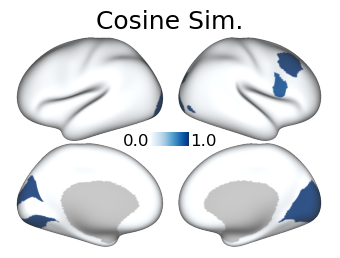

In [83]:
# Plotting brain plots: negative within-task similarity

file_out = figoutdir + "RSM_MeanSignificantNegSim_cosSim_wActFlowPred_withintask.png"
inputdata = meanSimNeg_cosSim_wt_byregion_nanzeroed_survived

#flip hemispheres, since CAB-NP is ordered left-to-right, while wbplot uses right-to-left
inputdata_flipped=np.zeros(np.shape(inputdata))
inputdata_flipped[0:180]=inputdata[180:360]
inputdata_flipped[180:360]=inputdata[0:180]

#Set to all reds if no negative values
# if min(inputdata) >= 0:
#     colormap='Reds'
# else:
#     colormap='seismic'

vmin, vmax = np.min(inputdata), np.max(inputdata)

colormap='Blues'
wbplot.pscalar(
        file_out=file_out,
        pscalars=inputdata_flipped,
        vrange = (vmin,vmax),
        cmap=colormap,
        transparent=True)

plt.figure(figsize=(3.5,3))
ax = plt.subplot(111)
im = img.imread(file_out) 
plt.imshow(im)
plt.axis('off')
plt.title('Cosine Sim.',fontsize=18)

# vmin, vmax = -2, 2
cnorm = clrs.Normalize(vmin=vmin, vmax=vmax)  # only important for tick placing
cmap = plt.get_cmap(colormap)
cax = ax.inset_axes([0.44, 0.48, 0.12, 0.07])
cbar = colorbar.ColorbarBase(
    cax, cmap=cmap, norm=cnorm, orientation='horizontal')
#cbar.set_ticks([-2, 2])  # don't need to do this since we're going to hide them
cax.get_xaxis().set_tick_params(length=0, pad=-2)
cbar.set_ticklabels([])
cbar.outline.set_visible(False)
cax.text(-0.025, 0.4, str(round(vmin,2)), ha='right', va='center', transform=cax.transAxes,
         fontsize=12);
cax.text(1.025, 0.4, str(round(vmax,2)), ha='left', va='center', transform=cax.transAxes,
         fontsize=12);
plt.tight_layout()
plt.savefig(figoutdir + 'RSM_MeanSignificantNegSim_cosSim_wActFlowPred_withintask.pdf',transparent=True)

pixdim[1,2,3] should be non-zero; setting 0 dims to 1

Info: Time to read /tmp/HumanCorticalParcellations/S1200.L.flat.32k_fs_LR.surf.gii was 0.045861 seconds.


Info: Time to read /tmp/HumanCorticalParcellations/S1200.L.inflated_MSMAll.32k_fs_LR.surf.gii was 0.018518 seconds.


Info: Time to read /tmp/HumanCorticalParcellations/S1200.L.midthickness_MSMAll.32k_fs_LR.surf.gii was 0.028568 seconds.


Info: Time to read /tmp/HumanCorticalParcellations/S1200.L.very_inflated_MSMAll.32k_fs_LR.surf.gii was 0.017528 seconds.


Info: Time to read /tmp/HumanCorticalParcellations/S1200.R.flat.32k_fs_LR.surf.gii was 0.044236 seconds.


Info: Time to read /tmp/HumanCorticalParcellations/S1200.R.inflated_MSMAll.32k_fs_LR.surf.gii was 0.018377 seconds.


Info: Time to read /tmp/HumanCorticalParcellations/S1200.R.midthickness_MSMAll.32k_fs_LR.surf.gii was 0.028532 seconds.


Info: Time to read /tmp/HumanCorticalParcellations/S1200.R.very_inflated_MSMAll.32k_fs_LR.surf.gii was 0.017325 seconds.


Info:

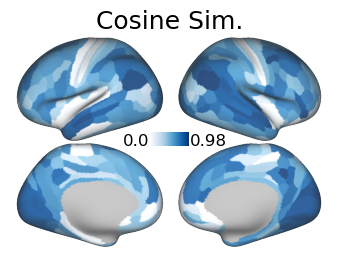

In [80]:
# Plotting brain plots: negative cross-task similarity

file_out = figoutdir + "RSM_MeanSignificantNegSim_cosSim_wActFlowPred.png"
inputdata = meanSimNeg_cosSim_ct_byregion_nanzeroed_survived

#flip hemispheres, since CAB-NP is ordered left-to-right, while wbplot uses right-to-left
inputdata_flipped=np.zeros(np.shape(inputdata))
inputdata_flipped[0:180]=inputdata[180:360]
inputdata_flipped[180:360]=inputdata[0:180]

#Set to all reds if no negative values
# if min(inputdata) >= 0:
#     colormap='Reds'
# else:
#     colormap='seismic'

vmin, vmax = np.min(inputdata), np.max(inputdata)

colormap='Blues'
wbplot.pscalar(
        file_out=file_out,
        pscalars=inputdata_flipped,
        vrange = (vmin,vmax),
        cmap=colormap,
        transparent=True)

plt.figure(figsize=(3.5,3))
ax = plt.subplot(111)
im = img.imread(file_out) 
plt.imshow(im)
plt.axis('off')
plt.title('Cosine Sim.',fontsize=18)

# vmin, vmax = -2, 2
cnorm = clrs.Normalize(vmin=vmin, vmax=vmax)  # only important for tick placing
cmap = plt.get_cmap(colormap)
cax = ax.inset_axes([0.44, 0.48, 0.12, 0.07])
cbar = colorbar.ColorbarBase(
    cax, cmap=cmap, norm=cnorm, orientation='horizontal')
#cbar.set_ticks([-2, 2])  # don't need to do this since we're going to hide them
cax.get_xaxis().set_tick_params(length=0, pad=-2)
cbar.set_ticklabels([])
cbar.outline.set_visible(False)
cax.text(-0.025, 0.4, str(round(vmin,2)), ha='right', va='center', transform=cax.transAxes,
         fontsize=12);
cax.text(1.025, 0.4, str(round(vmax,2)), ha='left', va='center', transform=cax.transAxes,
         fontsize=12);
plt.tight_layout()
plt.savefig(figoutdir + 'RSM_MeanSignificantNegSim_cosSim_wActFlowPred.pdf',transparent=True)

In [58]:
allsub_this_pair_meanSim_pos_nanzeroed.shape

(18, 360, 16, 16)

In [28]:
# network-wise

# pairwise_meanSimPos_bynet = np.zeros((nNetw,nTask,nTask))
# pairwise_meanSimPos_bynet_pred = np.zeros((nNetw,nTask,nTask))
allsub_pairwise_meanSimPos_bynet = np.zeros((nSub,nNetw,nTask,nTask))
allsub_pairwise_meanSimPos_pred_bynet = np.zeros((nSub,nNetw,nTask,nTask))

for netwIdx in range(nNetw):
    thisnet_roiIdx = np.where(networkdef==netwIdx+1)[0]
    
    # pairwise_meanSimPos_bynet[netwIdx,:,:] = np.mean(this_pair_meanSim_pos_nanzeroed[thisnet_roiIdx,:,:],axis=0)    
    # pairwise_meanSimPos_bynet_pred[netwIdx,:,:] = np.mean(this_pair_meanSim_pos_pred_nanzeroed[thisnet_roiIdx,:,:],axis=0)

    allsub_pairwise_meanSimPos_bynet[:,netwIdx,:,:] = np.mean(allsub_this_pair_meanSim_pos_nanzeroed[:,thisnet_roiIdx,:,:],axis=1)
    allsub_pairwise_meanSimPos_pred_bynet[:,netwIdx,:,:] = np.mean(allsub_this_pair_meanSim_pos_pred_nanzeroed[:,thisnet_roiIdx,:,:],axis=1)

In [41]:
# Get example values to highlight in the figure
# Go-NoGo vs Word-prediction: (4,6)
# Obj n-back vs verbal n-back: (11,12)
# VIS1 netwID: 0, FPN netwID: 6

print('VIS1 network (obs.): Go-NoGo vs Word-prediction:', pairwise_meanSimPos_bynet[0,4,6])
print('VIS1 network (obs.): Obj n-back vs verbal n-back:', pairwise_meanSimPos_bynet[0,11,12])
print('VIS1 network (pred.): Go-NoGo vs Word-prediction:', pairwise_meanSimPos_bynet_pred[0,4,6])
print('VIS1 network (pred.): Obj n-back vs verbal n-back:', pairwise_meanSimPos_bynet_pred[0,11,12])
print('\n')
print('FPN network (obs.): Go-NoGo vs Word-prediction:', pairwise_meanSimPos_bynet[6,4,6])
print('FPN network (obs.): Obj n-back vs verbal n-back:', pairwise_meanSimPos_bynet[6,11,12])
print('FPN network (pred.): Go-NoGo vs Word-prediction:', pairwise_meanSimPos_bynet_pred[6,4,6])
print('FPN network (pred.): Obj n-back vs verbal n-back:', pairwise_meanSimPos_bynet_pred[6,11,12])

VIS1 network (obs.): Go-NoGo vs Word-prediction: 0.4460704827966593
VIS1 network (obs.): Obj n-back vs verbal n-back: 0.18482182494999275
VIS1 network (pred.): Go-NoGo vs Word-prediction: 0.7707915377979976
VIS1 network (pred.): Obj n-back vs verbal n-back: 0.4073389884418614


FPN network (obs.): Go-NoGo vs Word-prediction: 0.24572879440518672
FPN network (obs.): Obj n-back vs verbal n-back: 0.30690481859268376
FPN network (pred.): Go-NoGo vs Word-prediction: 0.4447999676507988
FPN network (pred.): Obj n-back vs verbal n-back: 0.574032673340835


In [85]:
# Null network means

n_groupnullperm = 1000

pairwise_meanSimPos_bynet_pred_connperm = np.zeros((nNetw,nTask,nTask,n_groupnullperm))
pairwise_meanSimNeg_bynet_pred_connperm = np.zeros((nNetw,nTask,nTask,n_groupnullperm))

for netwIdx in range(nNetw):
    thisnet_roiIdx = np.where(networkdef==netwIdx+1)[0]
    
    for groupnullIdx in range(n_groupnullperm): 
    
        pairwise_meanSimPos_bynet_pred_connperm[netwIdx,:,:,groupnullIdx] = np.mean(this_pair_meanSim_pos_pred_groupnull_nanzeroed[thisnet_roiIdx,:,:,groupnullIdx],axis=0)
        pairwise_meanSimNeg_bynet_pred_connperm[netwIdx,:,:,groupnullIdx] = np.mean(this_pair_meanSim_neg_pred_groupnull_nanzeroed[thisnet_roiIdx,:,:,groupnullIdx],axis=0)

<Axes: >

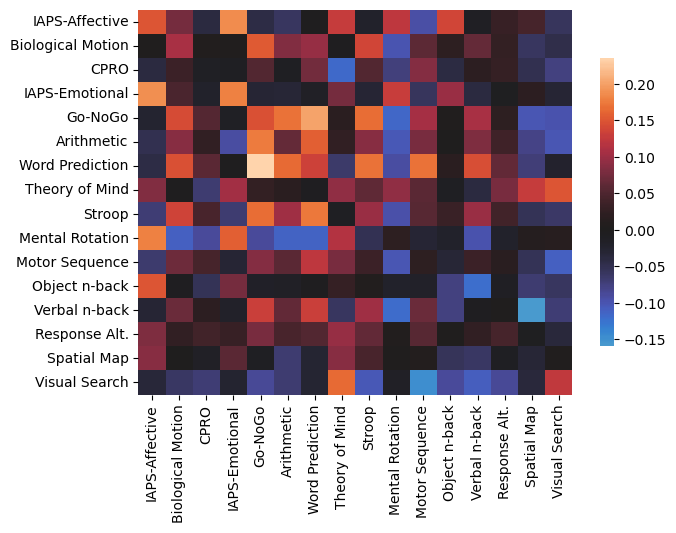

In [52]:
# Checking for other possible contrasting cross-task combinations between VIS1 and FPN

VIS2_FPN_netw_diff = pairwise_meanSimPos_bynet[0,:,:] - pairwise_meanSimPos_bynet[6,:,:]

fig,ax = plt.subplots(figsize=(7,5))
sns.heatmap(VIS2_FPN_netw_diff, xticklabels=tasknames, yticklabels=tasknames,
            center=0,ax=ax, cbar_kws={"shrink": 0.75})

In [33]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Function to prepare the data for plotting
def prepare_similarity_dataframe(data, task_indices, network_indices, combinations, category_label):
    def get_task_pair_similarities(network_idx, task1_idx, task2_idx):
        sim_forward = data[:, network_idx, task1_idx, task2_idx]
        sim_backward = data[:, network_idx, task2_idx, task1_idx]
        return (sim_forward + sim_backward) / 2

    df_data = []
    for task1_name, task2_name in combinations:
        task1_idx = task_indices[task1_name]
        task2_idx = task_indices[task2_name]
        pair_name = f"{task1_name}-\n{task2_name}"

        for network_name, network_idx in network_indices.items():
            sims = get_task_pair_similarities(network_idx, task1_idx, task2_idx)
            for subject_idx, sim in enumerate(sims):
                df_data.append({
                    'Task Pair': pair_name,
                    'Network': network_name,
                    'Similarity': sim,
                    'Category': category_label,
                    'Subject': subject_idx
                })

    return pd.DataFrame(df_data)

# Function to plot a single boxplot and stripplot
def plot_similarity_boxplot(ax, df, title,xlabel=False):
    
    sns.stripplot(
        data=df,
        x='Task Pair',
        y='Similarity',
        hue='Network',
        alpha=0.4, s=10,
        palette='magma',
        dodge=True,
        legend=False,
        ax=ax
    )
    sns.boxplot(
        data=df,
        x='Task Pair',
        y='Similarity',
        hue='Network',
        whis=[2.5, 97.5],
        palette='magma',
        width=0.6,
        linewidth=4,
        dodge=True,
        showfliers=False,
        ax=ax
    )
    ax.legend(fontsize=20)
    
    # ax.set_title(title, fontsize=22, pad=20)
    if xlabel:
        ax.set_xlabel('Task Pairs', labelpad=10, fontsize=32)
    else:
        ax.set_xlabel('')
    
    ax.set_ylabel('Cross-Task Similarity \n'+'('+title+')', labelpad=10, fontsize=32)
    ax.tick_params(axis='x', rotation=45)
    ax.tick_params(axis='both', labelsize=28)
    ax.xaxis.set_tick_params(width=4)
    ax.yaxis.set_tick_params(width=4)
    ax.axvline(2.5,linestyle='--',color='k',linewidth=4)
    sns.despine(ax=ax)

# Function to create vertically stacked plots
def create_stacked_similarity_plots(actual_data, predicted_data, task_indices, network_indices, combinations):
    # Prepare DataFrames
    stimulus_combinations = combinations['stimulus']
    executive_combinations = combinations['executive']

    actual_df = pd.concat([
        prepare_similarity_dataframe(actual_data, task_indices, network_indices, stimulus_combinations, 'Shared Stimulus (Word)'),
        prepare_similarity_dataframe(actual_data, task_indices, network_indices, executive_combinations, 'Shared Function (WM)')
    ])
    predicted_df = pd.concat([
        prepare_similarity_dataframe(predicted_data, task_indices, network_indices, stimulus_combinations, 'Shared Stimulus (Word)'),
        prepare_similarity_dataframe(predicted_data, task_indices, network_indices, executive_combinations, 'Shared Function (WM)')
    ])

    # Create subplots
    fig, axes = plt.subplots(2, 1, figsize=(14, 16), sharex=True)

    # Plot actual data
    plot_similarity_boxplot(axes[0], actual_df, 'Observed',xlabel=False)

    # Plot predicted data
    plot_similarity_boxplot(axes[1], predicted_df, 'Model-Predicted',xlabel=True)

    # Adjust layout
    plt.tight_layout()
    return fig

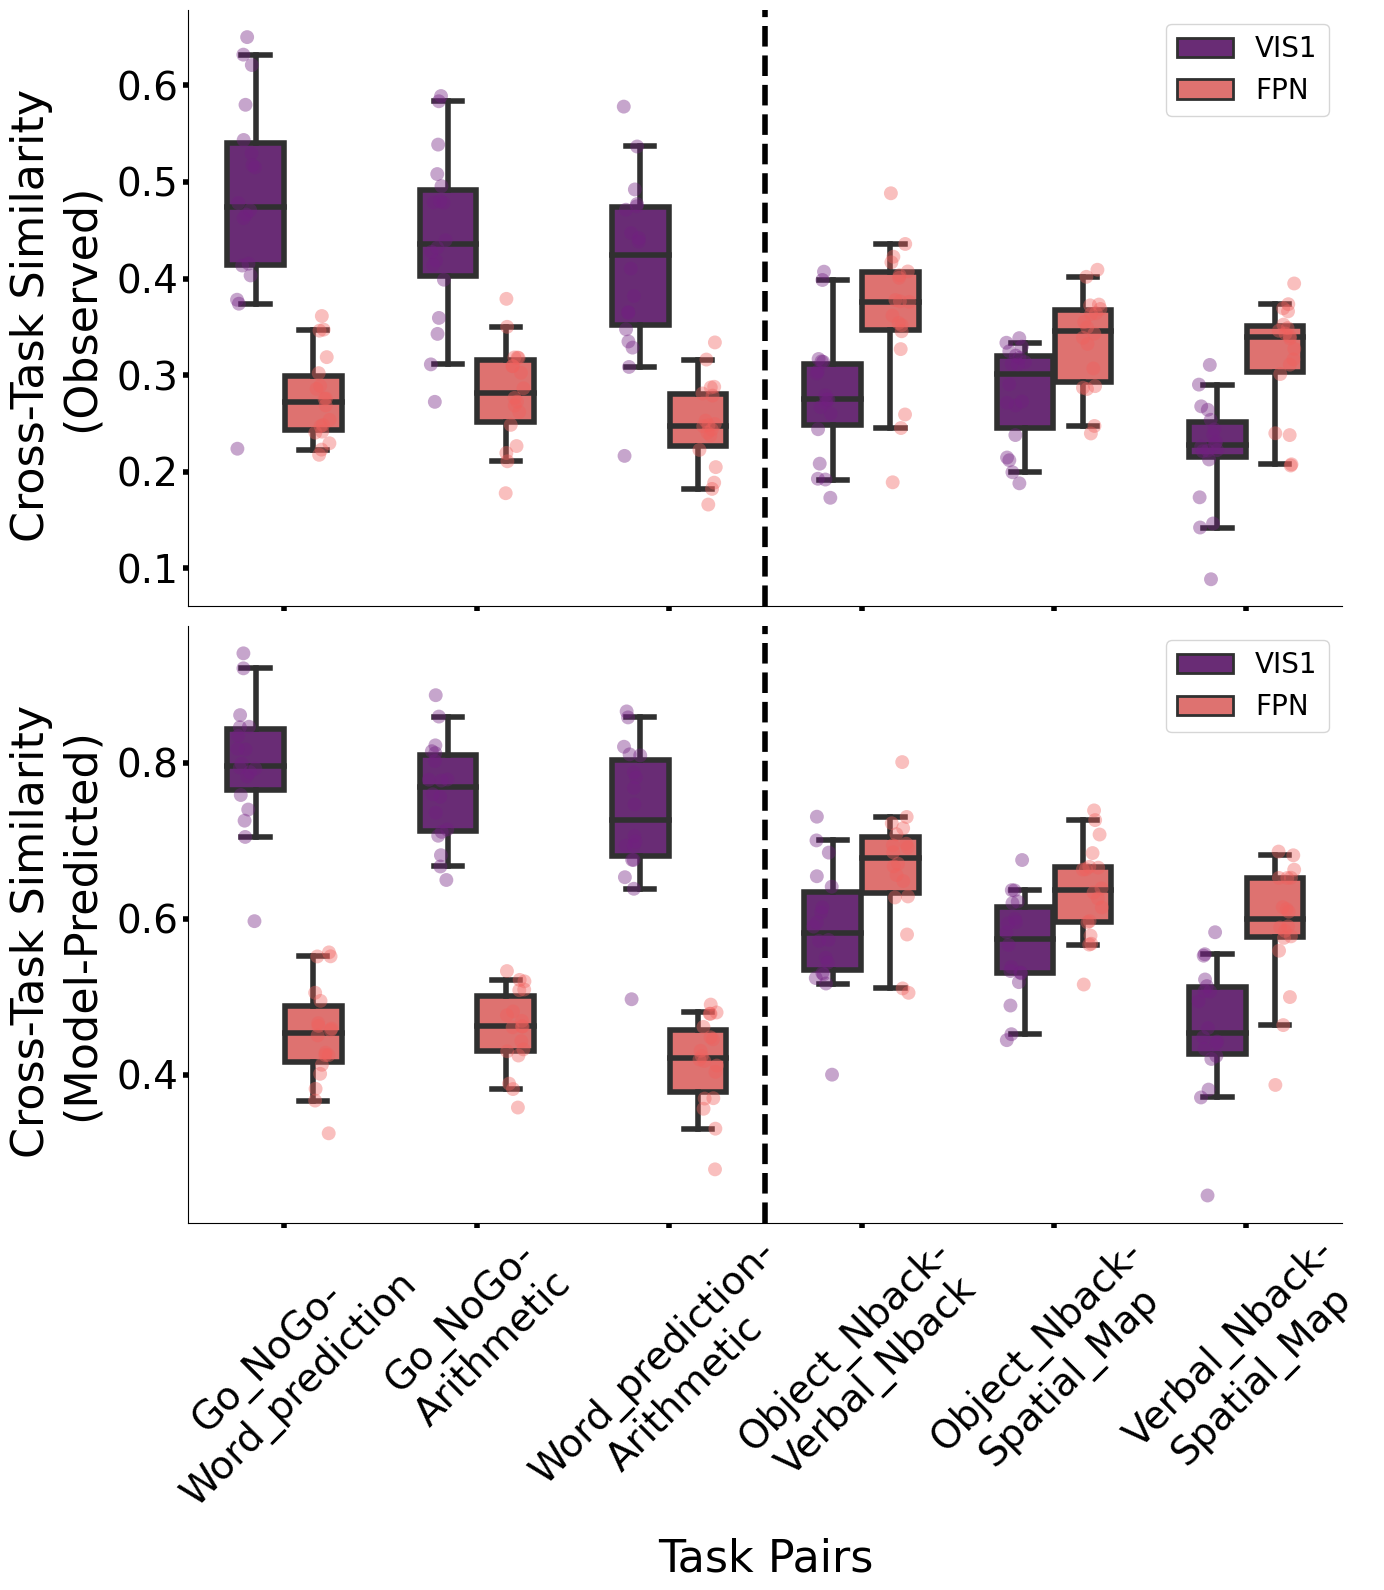

In [34]:
# Task indices and combinations
task_indices = {
    'Go_NoGo': 4,
    'Word_prediction': 6,
    'Arithmetic': 5,
    'Object_Nback': 11,
    'Verbal_Nback': 12,
    'Spatial_Map': 14
}
network_indices = {'VIS1': 0, 'FPN': 6}
combinations = {
    'stimulus': [('Go_NoGo', 'Word_prediction'), ('Go_NoGo', 'Arithmetic'), ('Word_prediction', 'Arithmetic')],
    'executive': [('Object_Nback', 'Verbal_Nback'), ('Object_Nback', 'Spatial_Map'), ('Verbal_Nback', 'Spatial_Map')]
}

# Call the function with actual and predicted data
fig = create_stacked_similarity_plots(
    allsub_pairwise_meanSimPos_bynet,
    allsub_pairwise_meanSimPos_pred_bynet,
    task_indices,
    network_indices,
    combinations
)

plt.savefig(figoutdir + 'TaskCombinations_obs_pred_crosstasksim_comparison.pdf',transparent = True)

plt.show()

In [21]:
def generate_paired_values(data, task_indices, network_indices, combinations):
    """
    Generate paired similarity values for statistical analysis.
    
    Parameters:
        data (numpy array): The similarity data (actual or predicted).
        task_indices (dict): Dictionary mapping task names to indices.
        network_indices (dict): Dictionary mapping network names to indices.
        combinations (dict): Dictionary containing 'stimulus' and 'executive' task combinations.
    
    Returns:
        paired_values (dict): A dictionary containing paired similarity values for each task pair.
    """
    paired_values = {}

    def get_task_pair_similarities(network_idx, task1_idx, task2_idx):
        sim_forward = data[:, network_idx, task1_idx, task2_idx]
        sim_backward = data[:, network_idx, task2_idx, task1_idx]
        return (sim_forward + sim_backward) / 2
    
    # Process stimulus combinations
    for task1_name, task2_name in combinations['stimulus']:
        task1_idx = task_indices[task1_name]
        task2_idx = task_indices[task2_name]
        pair_name = f"{task1_name}-\n{task2_name}"
        
        # Calculate similarities for each network
        vis1_sims = get_task_pair_similarities(network_indices['VIS1'], task1_idx, task2_idx)
        fpn_sims = get_task_pair_similarities(network_indices['FPN'], task1_idx, task2_idx)
        
        # Store paired values
        paired_values[pair_name] = {
            'VIS1': vis1_sims,
            'FPN': fpn_sims,
            'Category': 'Shared Stimulus (Word)'
        }
    
    # Process executive function combinations
    for task1_name, task2_name in combinations['executive']:
        task1_idx = task_indices[task1_name]
        task2_idx = task_indices[task2_name]
        pair_name = f"{task1_name}-\n{task2_name}"
        
        # Calculate similarities for each network
        vis1_sims = get_task_pair_similarities(network_indices['VIS1'], task1_idx, task2_idx)
        fpn_sims = get_task_pair_similarities(network_indices['FPN'], task1_idx, task2_idx)
        
        # Store paired values
        paired_values[pair_name] = {
            'VIS1': vis1_sims,
            'FPN': fpn_sims,
            'Category': 'Shared Function (WM)'
        }
    
    return paired_values

In [22]:
# Stats for observed data:

# Example usage:
# Define task indices, network indices, and combinations
task_indices = {
    'Go_NoGo': 4,
    'Word_prediction': 6,
    'Arithmetic': 5,
    'Object_Nback': 11,
    'Verbal_Nback': 12,
    'Spatial_Map': 14
}
network_indices = {'VIS1': 0, 'FPN': 6}
combinations = {
    'stimulus': [('Go_NoGo', 'Word_prediction'), ('Go_NoGo', 'Arithmetic'), ('Word_prediction', 'Arithmetic')],
    'executive': [('Object_Nback', 'Verbal_Nback'), ('Object_Nback', 'Spatial_Map'), ('Verbal_Nback', 'Spatial_Map')]
}

# Generate paired values for statistical analysis
paired_values = generate_paired_values(allsub_pairwise_meanSimPos_bynet, task_indices, network_indices, combinations)

# Perform statistical analysis
stats_results = perform_statistical_analysis(paired_values)

# Print detailed results
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
print("\nDetailed Statistical Results:")
print(stats_results)


Detailed Statistical Results:
                                            Category  Mean_VIS1  Mean_FPN  \
Object_Nback-\nSpatial_Map      Shared Function (WM)   0.280797  0.334712   
Verbal_Nback-\nSpatial_Map      Shared Function (WM)   0.221219  0.317689   
Object_Nback-\nVerbal_Nback     Shared Function (WM)   0.277318  0.363191   
Go_NoGo-\nArithmetic          Shared Stimulus (Word)   0.442668  0.280676   
Go_NoGo-\nWord_prediction     Shared Stimulus (Word)   0.481859  0.276078   
Word_prediction-\nArithmetic  Shared Stimulus (Word)   0.411910  0.248173   

                               SD_VIS1    SD_FPN  t_statistic       p_value  \
Object_Nback-\nSpatial_Map    0.048795  0.047572   -10.462080  7.953369e-09   
Verbal_Nback-\nSpatial_Map    0.053005  0.055750    -9.579034  2.897299e-08   
Object_Nback-\nVerbal_Nback   0.061803  0.070622    -6.148451  1.071850e-05   
Go_NoGo-\nArithmetic          0.084506  0.049788    11.983016  1.028269e-09   
Go_NoGo-\nWord_prediction     0.10

In [23]:
# Stats for predicted data:

# Generate paired values for statistical analysis
paired_values = generate_paired_values(allsub_pairwise_meanSimPos_pred_bynet, task_indices, network_indices, combinations)

# Perform statistical analysis
stats_results = perform_statistical_analysis(paired_values)

# Print detailed results
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
print("\nDetailed Statistical Results:")
print(stats_results)



Detailed Statistical Results:
                                            Category  Mean_VIS1  Mean_FPN  \
Verbal_Nback-\nSpatial_Map      Shared Function (WM)   0.461233  0.591787   
Object_Nback-\nSpatial_Map      Shared Function (WM)   0.564893  0.636271   
Object_Nback-\nVerbal_Nback     Shared Function (WM)   0.586688  0.663395   
Go_NoGo-\nWord_prediction     Shared Stimulus (Word)   0.798204  0.451405   
Go_NoGo-\nArithmetic          Shared Stimulus (Word)   0.761987  0.459155   
Word_prediction-\nArithmetic  Shared Stimulus (Word)   0.732332  0.416484   

                               SD_VIS1    SD_FPN  t_statistic       p_value  \
Verbal_Nback-\nSpatial_Map    0.078022  0.075544   -12.100119  8.860329e-10   
Object_Nback-\nSpatial_Map    0.062965  0.057982    -5.734026  2.433150e-05   
Object_Nback-\nVerbal_Nback   0.076728  0.071948    -4.469550  3.370078e-04   
Go_NoGo-\nWord_prediction     0.076604  0.062512    17.266120  3.257341e-12   
Go_NoGo-\nArithmetic          0.06

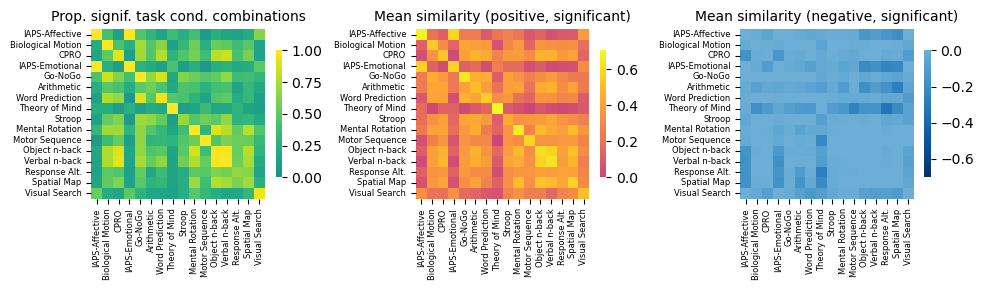

In [42]:
# Plotting prop signif, meanSimPos and meanSimNeg in example nets together (VIS1 and FPN)

fig,ax = plt.subplots(1, 3, figsize=(10,3))
ax1, ax2, ax3 = ax.flatten()

netwIdx = 6

abs_max = np.max([np.nanmax(pairwise_meanSimPos_bynet_pred[netwIdx,:,:]),np.abs(np.nanmin(pairwise_meanSimNeg_bynet_pred[netwIdx,:,:]))])

# Proportion significant
sns.heatmap(pairwise_signif_prop_bynet_pred[netwIdx,:,:], xticklabels=tasknames, yticklabels=tasknames,
            center=0,ax=ax1,cmap='viridis', vmin=0, vmax=1, cbar_kws={"shrink": 0.75})
ax1.set_xticklabels(ax1.get_xticklabels(),fontsize=6)
ax1.set_yticklabels(ax1.get_yticklabels(),fontsize=6)
ax1.set_title('Prop. signif. task cond. combinations', fontsize=10)

# Mean similarity (positive)
sns.heatmap(pairwise_meanSimPos_bynet_pred[netwIdx,:,:], xticklabels=tasknames, yticklabels=tasknames,
            center=0,ax=ax2,cmap='plasma',vmin=0,vmax=abs_max,cbar_kws={"shrink": 0.75})
ax2.set_xticklabels(ax2.get_xticklabels(),fontsize=6)
ax2.set_yticklabels(ax2.get_yticklabels(),fontsize=6)
ax2.set_title('Mean similarity (positive, significant)', fontsize=10)

# Mean similarity (negative)
sns.heatmap(pairwise_meanSimNeg_bynet_pred[netwIdx,:,:], xticklabels=tasknames, yticklabels=tasknames,
            center=0,ax=ax3,cmap='Blues_r',vmin=-abs_max,vmax=0,cbar_kws={"shrink": 0.75})
ax3.set_xticklabels(ax3.get_xticklabels(),fontsize=6)
ax3.set_yticklabels(ax3.get_yticklabels(),fontsize=6)
ax3.set_title('Mean similarity (negative, significant)', fontsize=10)

plt.subplots_adjust(wspace=0.5, hspace=0.7)

plt.tight_layout()
plt.savefig(figoutdir + 'RSM_survived_example_FPN_pred.pdf',transparent = True)
# Display the plots
plt.show()

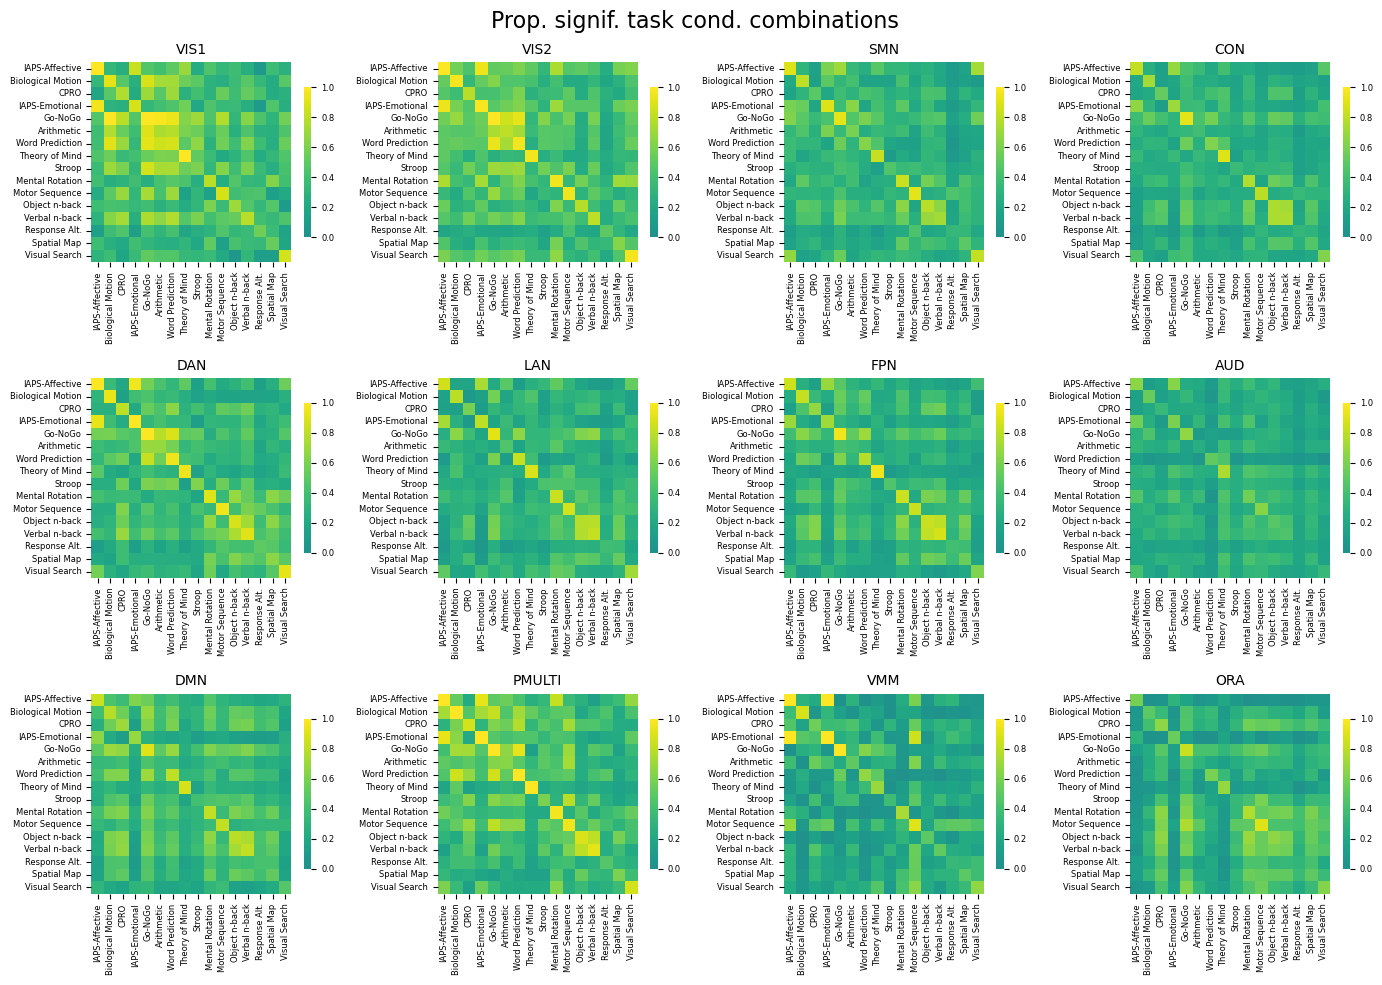

In [21]:
# Prop signif by net

fig, ax = plt.subplots(3, 4, figsize=(14, 10))

for netwIdx in range(nNetw):

    row = netwIdx // 4
    col = netwIdx % 4
    
    # Proportion significant
    heatmap = sns.heatmap(
        pairwise_signif_prop_bynet[netwIdx,:,:], 
        xticklabels=tasknames, 
        yticklabels=tasknames,
        center=0, 
        ax=ax[row, col], 
        cmap='viridis',
        vmin=0, vmax=1,
        cbar_kws={"shrink": 0.75}  # Optionally shrink the colorbar to fit
    )
    
    ax[row, col].set_xticklabels(ax[row, col].get_xticklabels(), fontsize=6)
    ax[row, col].set_yticklabels(ax[row, col].get_yticklabels(), fontsize=6)

    ax[row, col].set_title(networkNames[netwIdx], fontsize=10)
    
    # Reduce colorbar font size
    cbar = heatmap.collections[0].colorbar
    cbar.ax.tick_params(labelsize=6)  # Adjust the fontsize here

plt.subplots_adjust(wspace=0.5, hspace=0.7)

plt.suptitle("Prop. signif. task cond. combinations", fontsize=16)

plt.tight_layout()
plt.savefig(figoutdir + 'RSM_PropSignif_bynet.pdf',transparent = True)
plt.show()

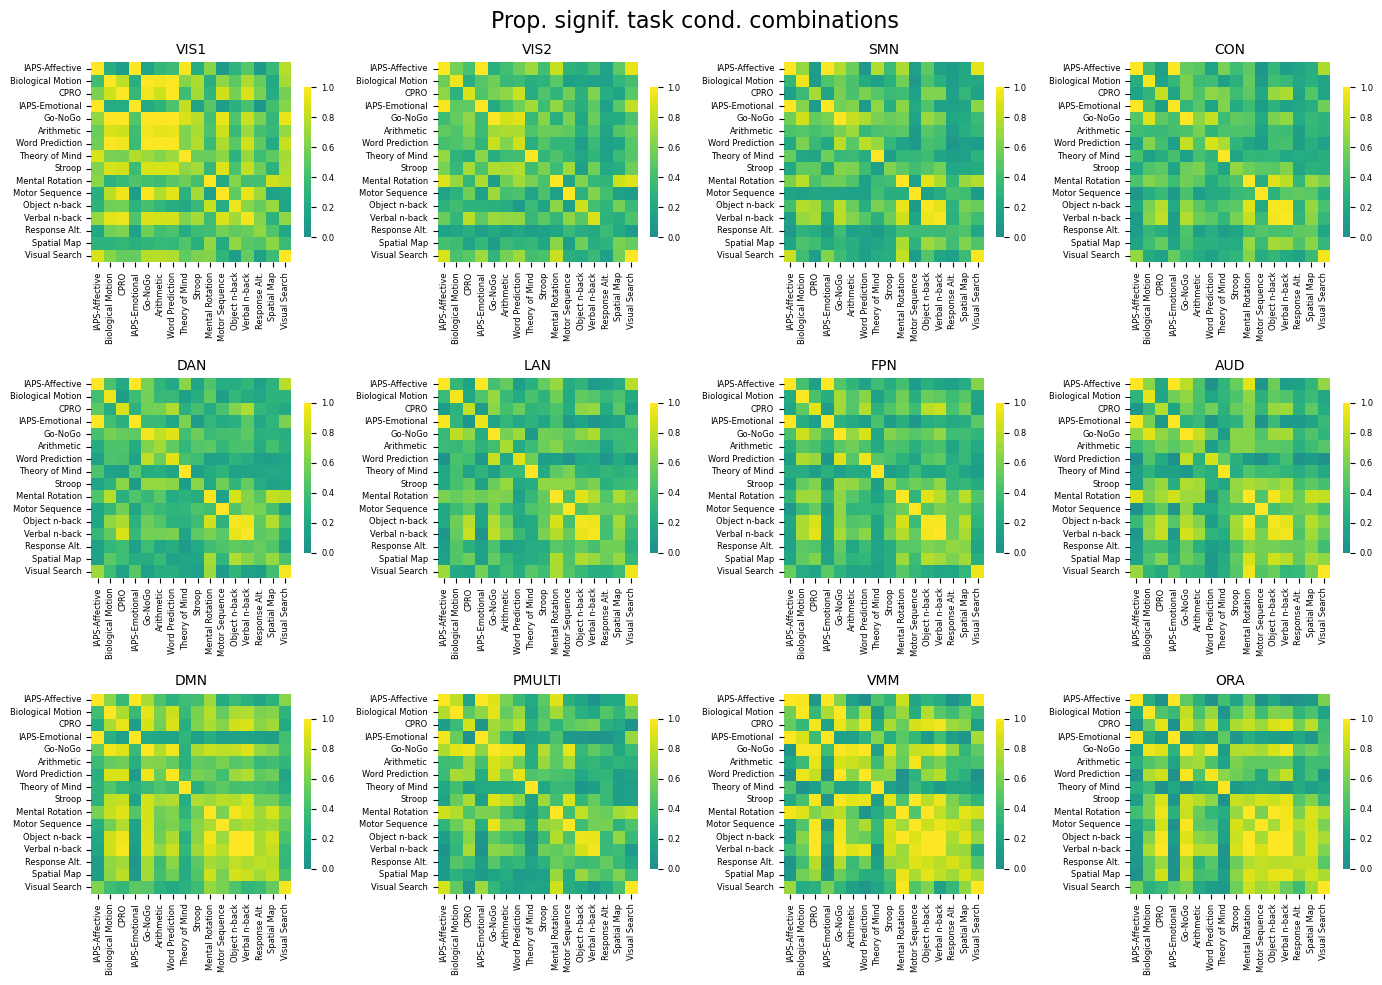

In [22]:
# Prop signif by net (predicted)

fig, ax = plt.subplots(3, 4, figsize=(14, 10))

for netwIdx in range(nNetw):

    row = netwIdx // 4
    col = netwIdx % 4
    
    # Proportion significant
    heatmap = sns.heatmap(
        pairwise_signif_prop_bynet_pred[netwIdx,:,:], 
        xticklabels=tasknames, 
        yticklabels=tasknames,
        center=0, 
        ax=ax[row, col], 
        cmap='viridis',
        vmin=0, vmax=1,
        cbar_kws={"shrink": 0.75}  # Optionally shrink the colorbar to fit
    )
    
    ax[row, col].set_xticklabels(ax[row, col].get_xticklabels(), fontsize=6)
    ax[row, col].set_yticklabels(ax[row, col].get_yticklabels(), fontsize=6)

    ax[row, col].set_title(networkNames[netwIdx], fontsize=10)
    
    # Reduce colorbar font size
    cbar = heatmap.collections[0].colorbar
    cbar.ax.tick_params(labelsize=6)  # Adjust the fontsize here

plt.subplots_adjust(wspace=0.5, hspace=0.7)

plt.suptitle("Prop. signif. task cond. combinations", fontsize=16)

plt.tight_layout()
plt.savefig(figoutdir + 'RSM_PropSignif_bynet_pred.pdf',transparent = True)
plt.show()

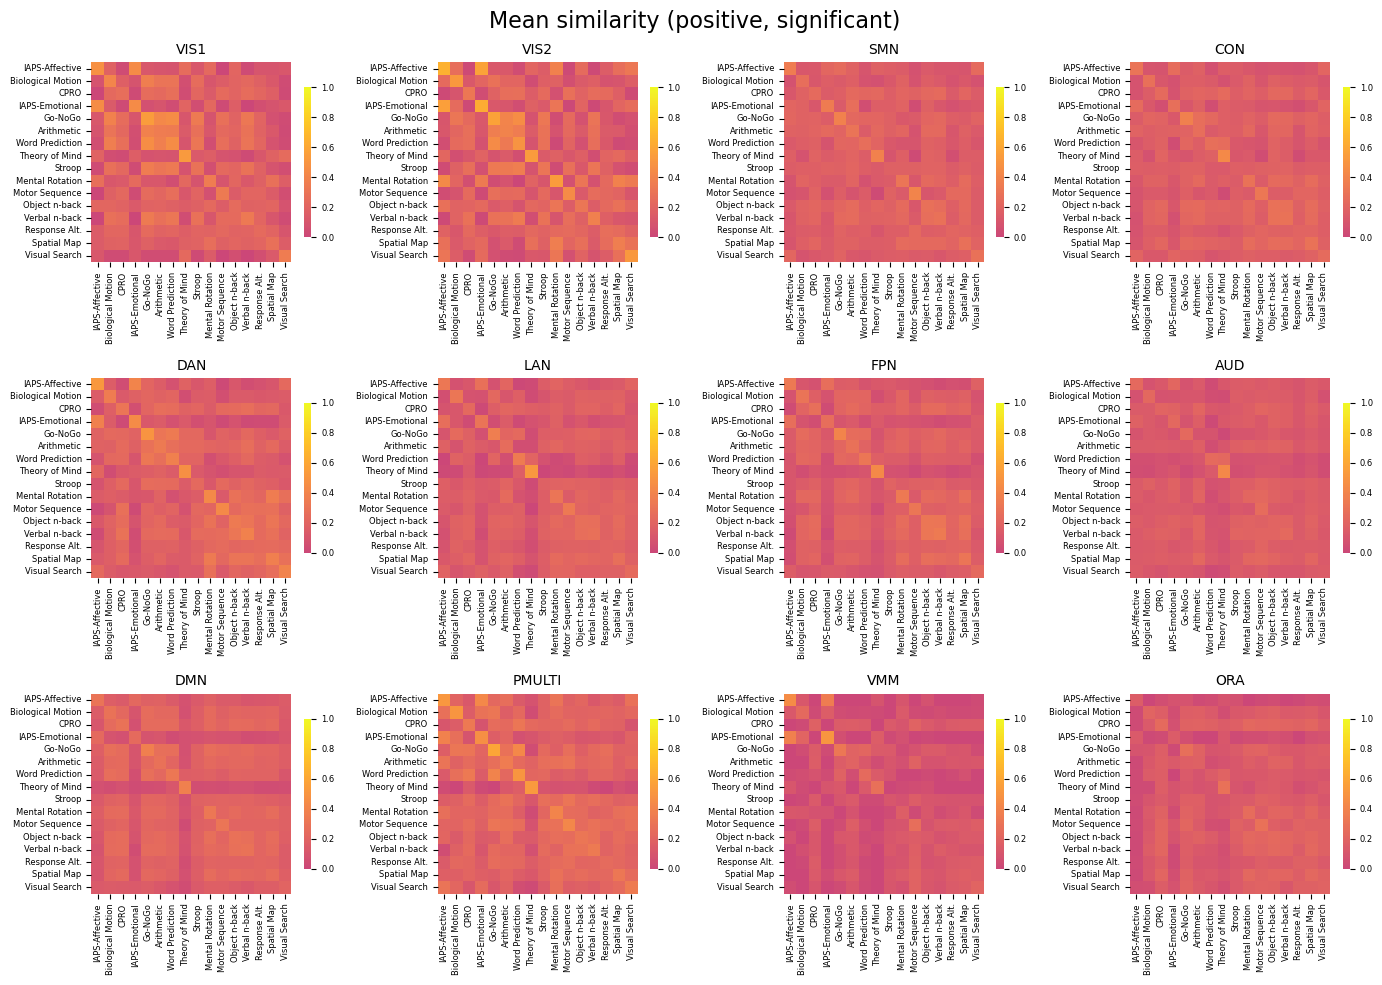

In [25]:
# Mean sim (positive) by net

fig, ax = plt.subplots(3, 4, figsize=(14, 10))

for netwIdx in range(nNetw):

    row = netwIdx // 4
    col = netwIdx % 4
    
    # Proportion significant
    heatmap = sns.heatmap(
        pairwise_meanSimPos_bynet[netwIdx,:,:], 
        xticklabels=tasknames, 
        yticklabels=tasknames,
        center=0, 
        ax=ax[row, col], 
        cmap='plasma',
        vmin=0, vmax=1,
        cbar_kws={"shrink": 0.75}  # Optionally shrink the colorbar to fit
    )
    
    ax[row, col].set_xticklabels(ax[row, col].get_xticklabels(), fontsize=6)
    ax[row, col].set_yticklabels(ax[row, col].get_yticklabels(), fontsize=6)

    ax[row, col].set_title(networkNames[netwIdx], fontsize=10)
    
    # Reduce colorbar font size
    cbar = heatmap.collections[0].colorbar
    cbar.ax.tick_params(labelsize=6)  # Adjust the fontsize here

plt.suptitle("Mean similarity (positive, significant)", fontsize=16)

plt.subplots_adjust(wspace=0.5, hspace=0.7)

plt.tight_layout()
plt.savefig(figoutdir + 'RSM_MeanSimPos_bynet.pdf',transparent = True)
plt.show()

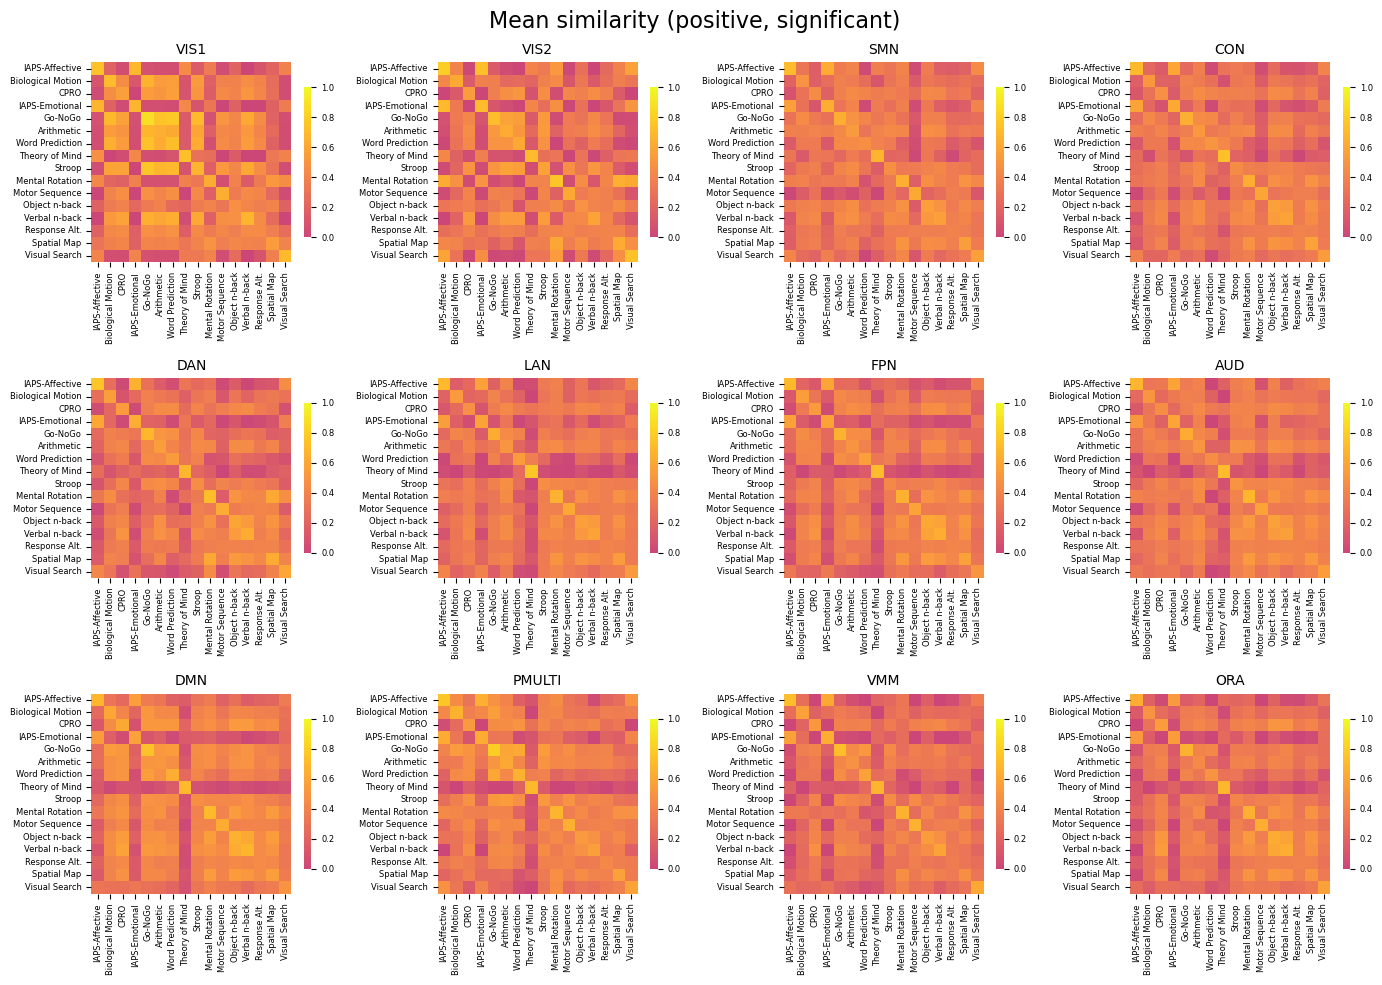

In [26]:
# Mean sim (positive) by net (predicted)

fig, ax = plt.subplots(3, 4, figsize=(14, 10))

for netwIdx in range(nNetw):

    row = netwIdx // 4
    col = netwIdx % 4
    
    # Proportion significant
    heatmap = sns.heatmap(
        pairwise_meanSimPos_bynet_pred[netwIdx,:,:], 
        xticklabels=tasknames, 
        yticklabels=tasknames,
        center=0, 
        ax=ax[row, col], 
        cmap='plasma',
        vmin=0, vmax=1,
        cbar_kws={"shrink": 0.75}  # Optionally shrink the colorbar to fit
    )
    
    ax[row, col].set_xticklabels(ax[row, col].get_xticklabels(), fontsize=6)
    ax[row, col].set_yticklabels(ax[row, col].get_yticklabels(), fontsize=6)

    ax[row, col].set_title(networkNames[netwIdx], fontsize=10)
    
    # Reduce colorbar font size
    cbar = heatmap.collections[0].colorbar
    cbar.ax.tick_params(labelsize=6)  # Adjust the fontsize here

plt.suptitle("Mean similarity (positive, significant)", fontsize=16)

plt.subplots_adjust(wspace=0.5, hspace=0.7)

plt.tight_layout()
plt.savefig(figoutdir + 'RSM_MeanSimPos_bynet_pred.pdf',transparent = True)
plt.show()

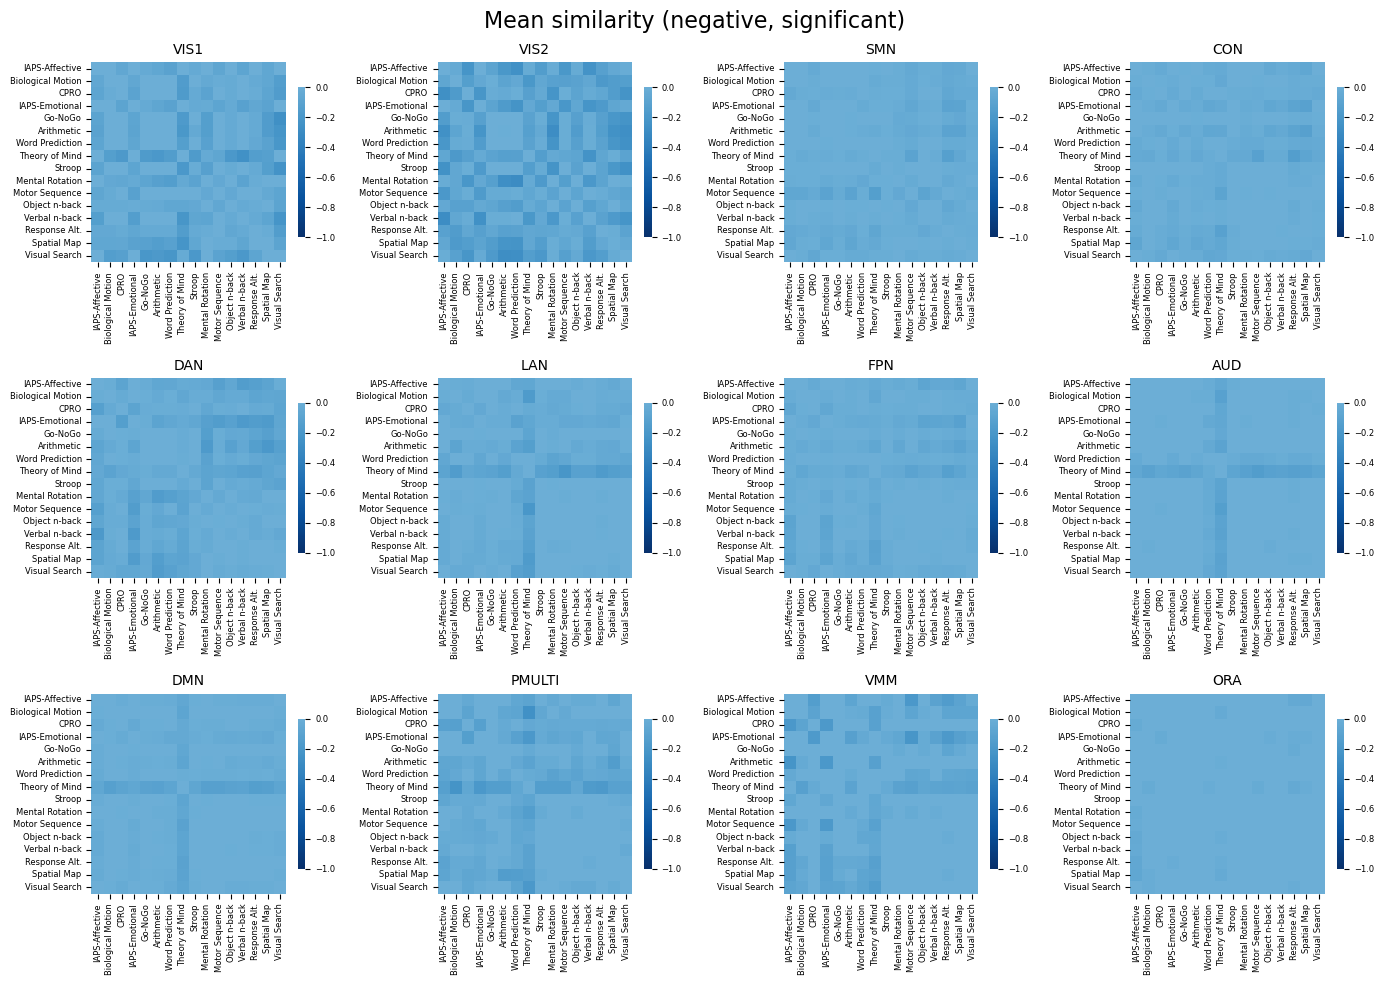

In [28]:
# Mean sim (negative) by net

fig, ax = plt.subplots(3, 4, figsize=(14, 10))

for netwIdx in range(nNetw):

    row = netwIdx // 4
    col = netwIdx % 4
    
    # Proportion significant
    heatmap = sns.heatmap(
        pairwise_meanSimNeg_bynet[netwIdx,:,:], 
        xticklabels=tasknames, 
        yticklabels=tasknames,
        center=0, 
        ax=ax[row, col], 
        cmap='Blues_r',
        vmin=-1, vmax=0,
        cbar_kws={"shrink": 0.75}  # Optionally shrink the colorbar to fit
    )
    
    ax[row, col].set_xticklabels(ax[row, col].get_xticklabels(), fontsize=6)
    ax[row, col].set_yticklabels(ax[row, col].get_yticklabels(), fontsize=6)

    ax[row, col].set_title(networkNames[netwIdx], fontsize=10)
    
    # Reduce colorbar font size
    cbar = heatmap.collections[0].colorbar
    cbar.ax.tick_params(labelsize=6)  # Adjust the fontsize here

plt.suptitle("Mean similarity (negative, significant)", fontsize=16)

plt.subplots_adjust(wspace=0.5, hspace=0.7)

plt.tight_layout()
plt.savefig(figoutdir + 'RSM_MeanSimNeg_bynet.pdf',transparent = True)
plt.show()

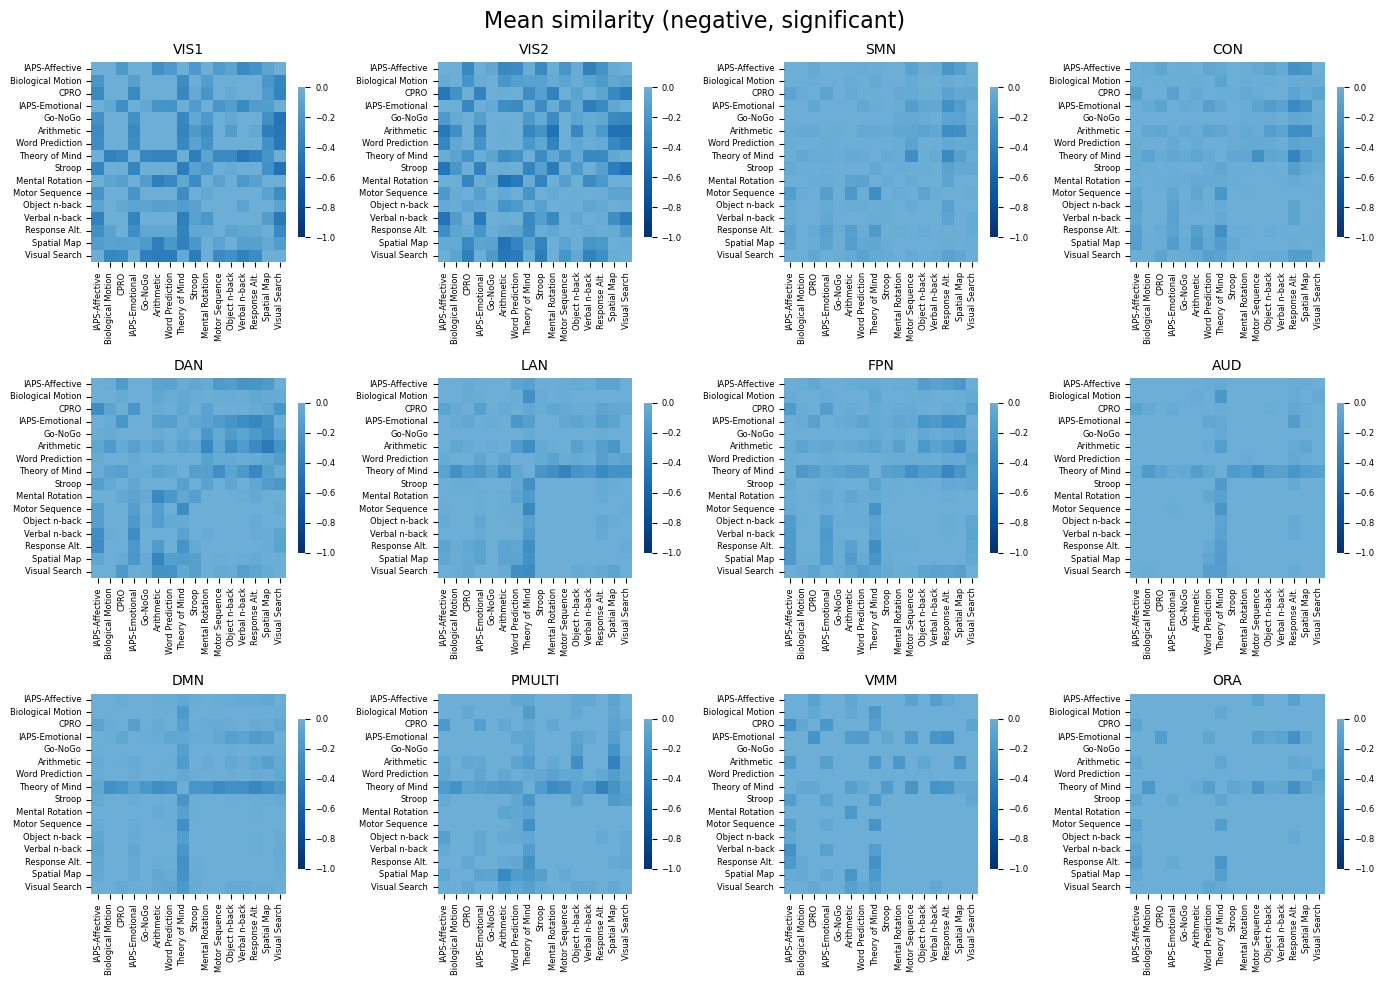

In [17]:
# Mean sim (negative) by net (predicted)

fig, ax = plt.subplots(3, 4, figsize=(14, 10))

for netwIdx in range(nNetw):

    row = netwIdx // 4
    col = netwIdx % 4
    
    # Proportion significant
    heatmap = sns.heatmap(
        pairwise_meanSimNeg_bynet_pred[netwIdx,:,:], 
        xticklabels=tasknames, 
        yticklabels=tasknames,
        center=0, 
        ax=ax[row, col], 
        cmap='Blues_r',
        vmin=-1, vmax=0,
        cbar_kws={"shrink": 0.75}  # Optionally shrink the colorbar to fit
    )
    
    ax[row, col].set_xticklabels(ax[row, col].get_xticklabels(), fontsize=6)
    ax[row, col].set_yticklabels(ax[row, col].get_yticklabels(), fontsize=6)

    ax[row, col].set_title(networkNames[netwIdx], fontsize=10)
    
    # Reduce colorbar font size
    cbar = heatmap.collections[0].colorbar
    cbar.ax.tick_params(labelsize=6)  # Adjust the fontsize here

plt.suptitle("Mean similarity (negative, significant)", fontsize=16)

plt.subplots_adjust(wspace=0.5, hspace=0.7)

plt.tight_layout()
plt.savefig(figoutdir + 'RSM_MeanSimNeg_bynet_pred.pdf',transparent = True)
plt.show()

In [89]:
# cosSim by net

meanSimPos_cosSim_wt_bynet, meanSimPos_cosSim_ct_bynet = get_tasklevel_cosSim_bynet(obs_mat=pairwise_meanSimPos_bynet,
                                                           pred_mat=pairwise_meanSimPos_bynet_pred)

meanSimNeg_cosSim_wt_bynet, meanSimNeg_cosSim_ct_bynet = get_tasklevel_cosSim_bynet(obs_mat=pairwise_meanSimNeg_bynet,
                                                           pred_mat=pairwise_meanSimNeg_bynet_pred)

/tmp/ipykernel_39095/456982238.py:24: RuntimeWarning: invalid value encountered in true_divide
  pred_withintask_normed = pred_withintask / np.linalg.norm(pred_withintask)
/tmp/ipykernel_39095/456982238.py:21: RuntimeWarning: invalid value encountered in true_divide
  obs_withintask_normed = obs_withintask / np.linalg.norm(obs_withintask)


In [92]:
# cosSim by net: connperm null

meanSimPos_cosSim_wt_bynet_null = np.zeros((nNetw,n_groupnullperm))
meanSimPos_cosSim_ct_bynet_null = np.zeros((nNetw,n_groupnullperm))
meanSimNeg_cosSim_wt_bynet_null = np.zeros((nNetw,n_groupnullperm))
meanSimNeg_cosSim_ct_bynet_null = np.zeros((nNetw,n_groupnullperm))

for groupnullIdx in range(n_groupnullperm):

    meanSimPos_cosSim_wt_bynet_null[:,groupnullIdx], meanSimPos_cosSim_ct_bynet_null[:,groupnullIdx] = get_tasklevel_cosSim_bynet(obs_mat=pairwise_meanSimPos_bynet,
                                                               pred_mat=pairwise_meanSimPos_bynet_pred_connperm[:,:,:,groupnullIdx])

    meanSimNeg_cosSim_wt_bynet_null[:,groupnullIdx], meanSimNeg_cosSim_ct_bynet_null[:,groupnullIdx] = get_tasklevel_cosSim_bynet(obs_mat=pairwise_meanSimNeg_bynet,
                                                               pred_mat=pairwise_meanSimNeg_bynet_pred_connperm[:,:,:,groupnullIdx])

/tmp/ipykernel_39095/456982238.py:21: RuntimeWarning: invalid value encountered in true_divide
  obs_withintask_normed = obs_withintask / np.linalg.norm(obs_withintask)


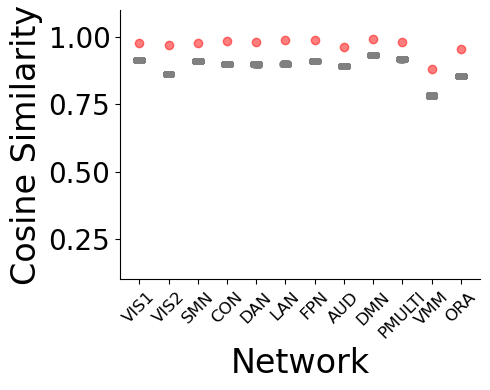

In [105]:
observed_values = meanSimPos_cosSim_ct_bynet
null_distributions = meanSimPos_cosSim_ct_bynet_null

# Step 2: Prepare data for strip plot
data = []
for i in range(nNetw):
    for j in range(n_groupnull):
        data.append([i, null_distributions[i, j]])
        
df = pd.DataFrame(data, columns=['Network', 'Null Value'])

# Step 3: Create the strip plot
plt.figure(figsize=(5, 4))

sns.stripplot(x='Network', y='Null Value', data=df, jitter=True, alpha=0.5, color='gray')

# Overlay the observed values
plt.scatter(x=np.arange(nNetw), y=observed_values, color='red', alpha=0.5,label=None, zorder=10)
plt.locator_params(axis='y', nbins=4)
plt.ylim([0.1,1.1])
plt.xticks(np.arange(nNetw),networkNames,fontsize=12,rotation=45)
plt.yticks(fontsize=20)

plt.xlabel('Network',fontsize=24)
plt.ylabel('Cosine Similarity',fontsize=24)

# plt.legend(fontsize=12)
sns.despine()
plt.tight_layout()
plt.savefig(figoutdir + 'meanSimPos_cosSim_ct_bynet_wConnPerm.pdf',transparent=True)

plt.show()

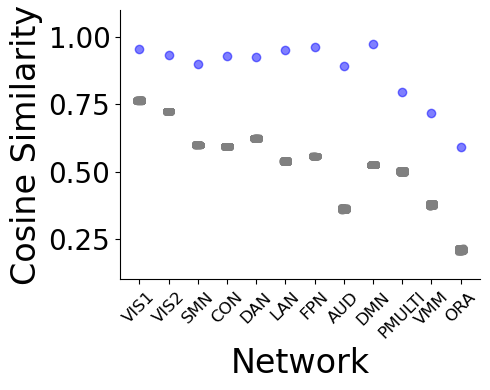

In [106]:
observed_values = meanSimNeg_cosSim_ct_bynet
null_distributions = meanSimNeg_cosSim_ct_bynet_null

# Step 2: Prepare data for strip plot
data = []
for i in range(nNetw):
    for j in range(n_groupnull):
        data.append([i, null_distributions[i, j]])
        
df = pd.DataFrame(data, columns=['Network', 'Null Value'])

# Step 3: Create the strip plot
plt.figure(figsize=(5, 4))

sns.stripplot(x='Network', y='Null Value', data=df, jitter=True, alpha=0.5, color='gray')

# Overlay the observed values
plt.scatter(x=np.arange(nNetw), y=observed_values, color='blue', alpha=0.5,label=None, zorder=10)
plt.locator_params(axis='y', nbins=4)
plt.ylim([0.1,1.1])
plt.xticks(np.arange(nNetw),networkNames,fontsize=12,rotation=45)
plt.yticks(fontsize=20)

plt.xlabel('Network',fontsize=24)
plt.ylabel('Cosine Similarity',fontsize=24)
# plt.legend(fontsize=12)
sns.despine()
plt.tight_layout()
plt.savefig(figoutdir + 'meanSimNeg_cosSim_ct_bynet_wConnPerm.pdf',transparent=True)

plt.show()

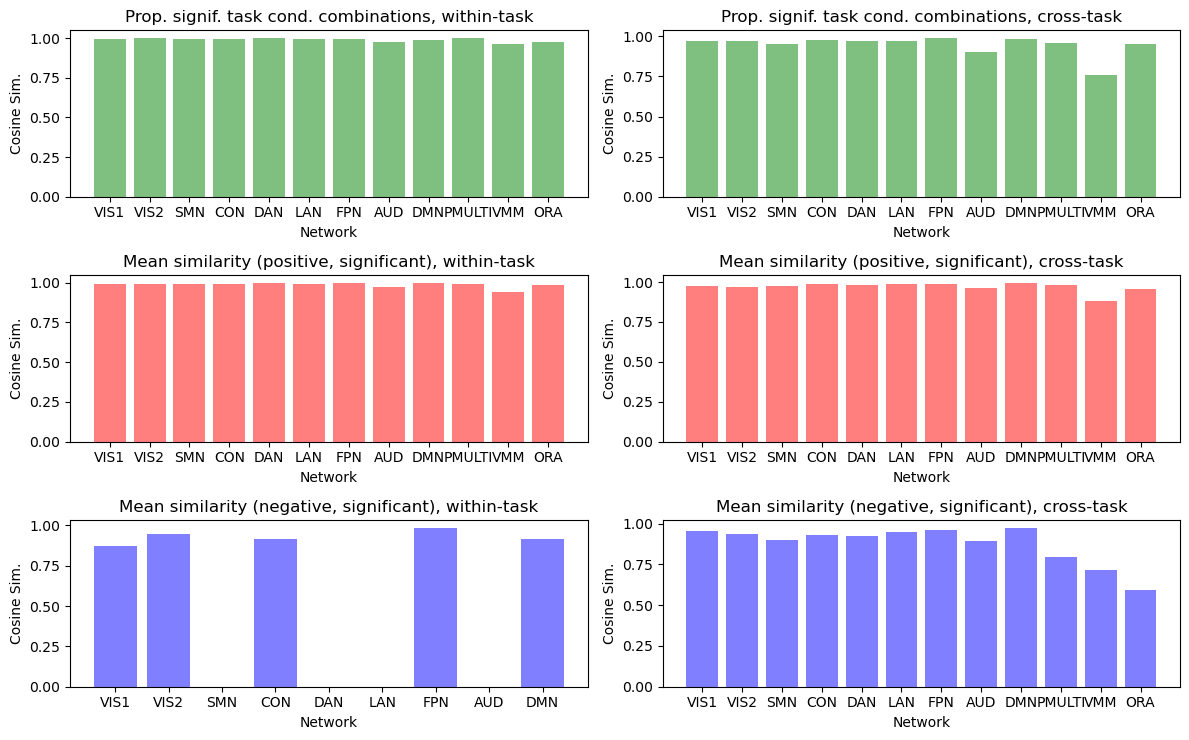

In [43]:
fig, axs = plt.subplots(3, 2, figsize=(12, 7.5))

axs[0,0].bar(networkNames, propSignif_cosSim_wt, color='green',alpha=0.5)
axs[0,0].set_title('Prop. signif. task cond. combinations, within-task')
axs[0,1].bar(networkNames, propSignif_cosSim_ct, color='green',alpha=0.5)
axs[0,1].set_title('Prop. signif. task cond. combinations, cross-task')

axs[1,0].bar(networkNames, meanSimPos_cosSim_wt, color='red',alpha=0.5)
axs[1,0].set_title('Mean similarity (positive, significant), within-task')
axs[1,1].bar(networkNames, meanSimPos_cosSim_ct, color='red',alpha=0.5)
axs[1,1].set_title('Mean similarity (positive, significant), cross-task')

axs[2,0].bar(networkNames, meanSimNeg_cosSim_wt, color='blue',alpha=0.5)
axs[2,0].set_title('Mean similarity (negative, significant), within-task')
axs[2,1].bar(networkNames, meanSimNeg_cosSim_ct, color='blue',alpha=0.5)
axs[2,1].set_title('Mean similarity (negative, significant), cross-task')

for ax in axs.flat:
    ax.set_xlabel('Network',fontsize=10)
    ax.set_ylabel('Cosine Sim.',fontsize=10)

# Adjust spacing between subplots
plt.subplots_adjust(hspace=0.5, wspace=0.5)
    
# Adjust layout to prevent overlap
plt.tight_layout()

plt.savefig(figoutdir + 'within_and_crosstask_obs_and_pred_cosSim_byNet.pdf',transparent=True)
plt.show()

## Mean cross-task and within-task similarity against compression/expansion

In [21]:
# Reading dimdiff (positive values are expansion)
with open(subProjDir + 'allsub_dim_diff.pkl', 'rb') as f1:
    dim_diff = pickle.load(f1)
    
with open(subProjDir + 'allsub_dim_diff_pred.pkl', 'rb') as f2:
    dim_diff_pred = pickle.load(f2)
    
with open(subProjDir + 'allsub_alltargetSVPR.pkl', 'rb') as f:
    allsub_SVPR = pickle.load(f)

meansub_dim_diff = np.mean(dim_diff,axis=0)
meansub_dim_diff_pred = np.mean(dim_diff_pred,axis=0)
meansub_SVPR = np.mean(allsub_SVPR,axis=0)

In [22]:
def get_within_and_crosstask_meansimilarity(mat):
    
    '''
    mat shape: (nParcels,nTask,nTask)
    '''
    
    # Get non-diagonal indices
    diag_indices = np.diag_indices_from(mat)

    # Create a mask that is True everywhere except the diagonal
    mask = np.ones(mat.shape, dtype=bool)
    mask[diag_indices] = False
    
    withintask_meansim = np.mean(mat[diag_indices])
    crosstask_meansim = np.mean(mat[mask])
    
    return withintask_meansim,crosstask_meansim

In [23]:
this_pair_meanSim_pos_nanzeroed.shape

(360, 16, 16)

In [24]:
# meanPropSig_wt = np.zeros(nParcels)
# meanPropSig_ct = np.zeros(nParcels)

pos_wt_meansim = np.zeros(nParcels)
pos_ct_meansim = np.zeros(nParcels)

# neg_wt_meansim = np.zeros(nParcels)
# neg_ct_meansim = np.zeros(nParcels)

for roiIdx in range(nParcels):

    # meanPropSig_wt[roiIdx],meanPropSig_ct[roiIdx] = get_within_and_crosstask_meansimilarity(this_pair_signif_prop[roiIdx,:,:])
    
    pos_wt_meansim[roiIdx],pos_ct_meansim[roiIdx] = get_within_and_crosstask_meansimilarity(this_pair_meanSim_pos_nanzeroed[roiIdx,:,:])
    # neg_wt_meansim[roiIdx],neg_ct_meansim[roiIdx] = get_within_and_crosstask_meansimilarity(this_pair_meanSim_neg_nanzeroed[roiIdx,:,:])

In [23]:
# Getting subject-wise pos_ct_meansim and neg_ct_meansim for significance

allsub_pos_ct_meansim = np.zeros((nSub,nParcels))
allsub_neg_ct_meansim = np.zeros((nSub,nParcels))

for subIdx in range(nSub):
    for roiIdx in range(nParcels):
        
        _,allsub_pos_ct_meansim[subIdx,roiIdx] = get_within_and_crosstask_meansimilarity(allsub_this_pair_meanSim_pos_nanzeroed[subIdx,roiIdx,:,:])
        _,allsub_neg_ct_meansim[subIdx,roiIdx] = get_within_and_crosstask_meansimilarity(allsub_this_pair_meanSim_neg_nanzeroed[subIdx,roiIdx,:,:])

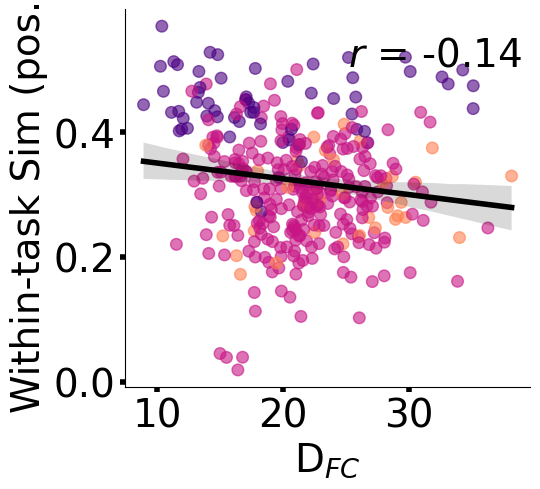

In [37]:
survived = pos_wt_meansim!=0

X = meansub_SVPR
Y = pos_wt_meansim
RAaxis = 'full_BS_custom'
xlabel = r'D$_{FC}$'
ylabel = 'Within-task Sim (pos.)'
outname = figoutdir + 'MeanWithintaskSimPos_vs_FCDim.pdf'

plottools.customScatterPlot(X,Y,RAaxis,xlabel,ylabel,outname,legLoc='TR',xmin=None,xmax=None,ymin=None,ymax=None,
                            custom_select=survived,invert_xaxis=False,deg=1,xtickbins=4,ytickbins=4,
                            plotwidth=5.5,showstat=True,regplot=True)

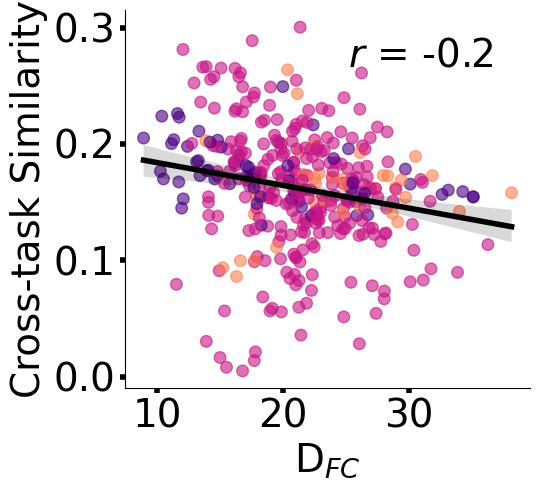

In [26]:
survived = pos_ct_meansim!=0

X = meansub_SVPR
Y = pos_ct_meansim
RAaxis = 'full_BS_custom'
xlabel = r'D$_{FC}$'
ylabel = 'Cross-task Similarity'
outname = figoutdir + 'MeanCrosstaskSimPos_vs_FCDim.pdf'

plottools.customScatterPlot(X,Y,RAaxis,xlabel,ylabel,outname,legLoc='TR',xmin=None,xmax=None,ymin=None,ymax=None,
                            custom_select=survived,invert_xaxis=False,deg=1,xtickbins=4,ytickbins=4,
                            plotwidth=5.5,showstat=True,regplot=True)

In [24]:
# Significance

survived = pos_ct_meansim!=0

X = allsub_SVPR[:,survived]
Y = allsub_pos_ct_meansim[:,survived]

allSub_r_full = np.zeros(nSub)

for subIdx in range(nSub):

    r_full,p1 = stats.pearsonr(X[subIdx,:],Y[subIdx,:])
    allSub_r_full[subIdx] = r_full

t_full,p_full = stats.ttest_1samp(np.arctanh(allSub_r_full), popmean=0, axis=0)

print('Positive ct meansim: t(17)=',t_full,' p=',p_full)

Positive ct meansim: t(17)= -16.853179836042607  p= 4.8109790551393455e-12


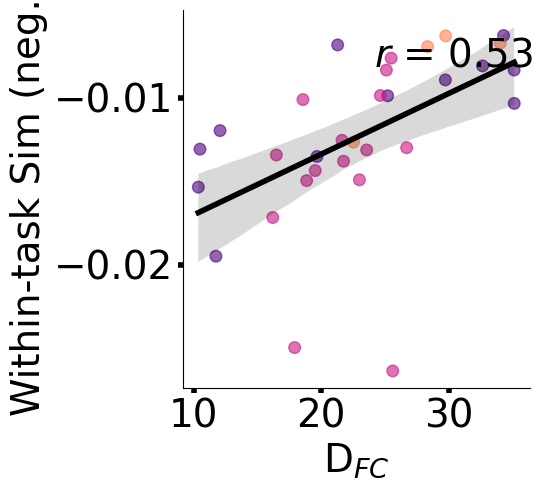

In [40]:
survived = neg_wt_meansim!=0

X = meansub_SVPR
Y = neg_wt_meansim
RAaxis = 'full_BS_custom'
xlabel = r'D$_{FC}$'
ylabel = 'Within-task Sim (neg.)'
outname = figoutdir + 'MeanWithintaskSimNeg_vs_FCDim.pdf'

plottools.customScatterPlot(X,Y,RAaxis,xlabel,ylabel,outname,legLoc='TR',xmin=None,xmax=None,ymin=None,ymax=None,
                            custom_select=survived,invert_xaxis=False,deg=1,xtickbins=4,ytickbins=4,
                            plotwidth=5.5,showstat=True,regplot=True)

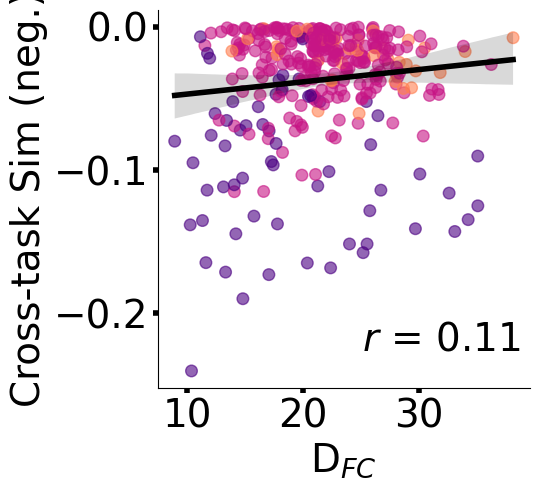

In [42]:
survived = neg_ct_meansim!=0

X = meansub_SVPR
Y = neg_ct_meansim
RAaxis = 'full_BS_custom'
xlabel = r'D$_{FC}$'
ylabel = 'Cross-task Sim (neg.)'
outname = figoutdir + 'MeanCrosstaskSimNeg_vs_FCDim.pdf'

plottools.customScatterPlot(X,Y,RAaxis,xlabel,ylabel,outname,legLoc='BR',xmin=None,xmax=None,ymin=None,ymax=None,
                            custom_select=survived,invert_xaxis=False,deg=1,xtickbins=4,ytickbins=4,
                            plotwidth=5.5,showstat=True,regplot=True)

In [26]:
# Significance

survived = neg_ct_meansim!=0

X = allsub_SVPR[:,survived]
Y = allsub_neg_ct_meansim[:,survived]

allSub_r_full = np.zeros(nSub)

for subIdx in range(nSub):

    r_full,p1 = stats.pearsonr(X[subIdx,:],Y[subIdx,:])
    allSub_r_full[subIdx] = r_full

t_full,p_full = stats.ttest_1samp(np.arctanh(allSub_r_full), popmean=0, axis=0)

print('Negative ct meansim: t(17)=',t_full,' p=',p_full)

Negative ct meansim: t(17)= 14.744219440516193  p= 4.0664255001228575e-11


In [28]:
allSub_r_full

array([0.1945593 , 0.10419508, 0.17008428, 0.10848989, 0.23692988,
       0.23484244, 0.16304318, 0.20372181, 0.26359506, 0.21528741,
       0.19586116, 0.23029162, 0.20551729, 0.11141697, 0.21664013,
       0.17871821, 0.23421929, 0.32487283])

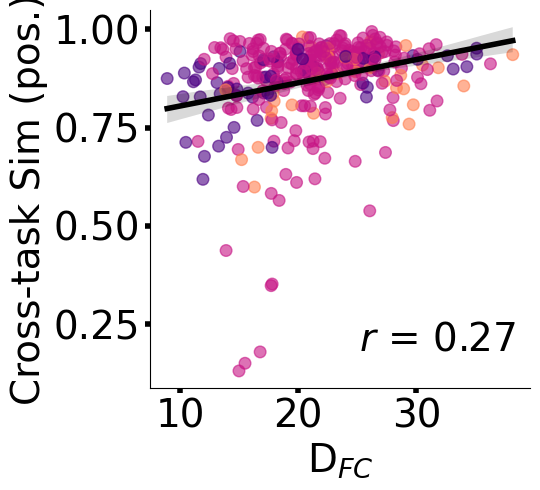

In [34]:
# Cross-task similarity prediction vs low-D connectivity



survived = meanSimPos_cosSim_ct_byregion_nanzeroed_survived!=0

X = meansub_SVPR
Y = meanSimPos_cosSim_ct_byregion_nanzeroed_survived
RAaxis = 'full_BS_custom'
xlabel = r'D$_{FC}$'
ylabel = 'Cross-task Sim (pos.)'
outname = figoutdir + 'meanSimPos_cosSim_ct_byregion_vs_FCDim.pdf'

plottools.customScatterPlot(X,Y,RAaxis,xlabel,ylabel,outname,legLoc='BR',xmin=None,xmax=None,ymin=None,ymax=None,
                            custom_select=survived,invert_xaxis=False,deg=1,xtickbins=4,ytickbins=4,
                            plotwidth=5.5,showstat=True,regplot=True)

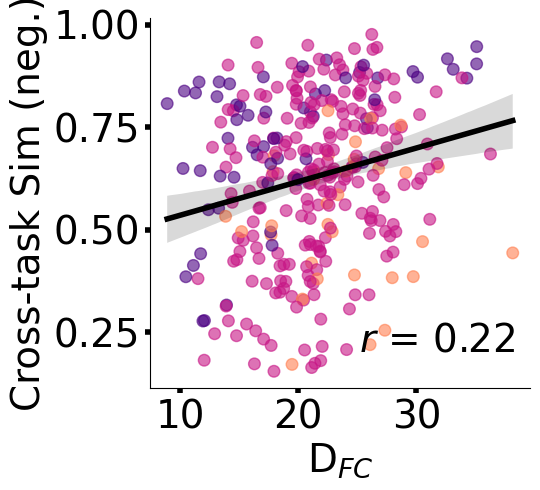

In [36]:
survived = meanSimNeg_cosSim_ct_byregion_nanzeroed_survived!=0

X = meansub_SVPR
Y = meanSimNeg_cosSim_ct_byregion_nanzeroed_survived
RAaxis = 'full_BS_custom'
xlabel = r'D$_{FC}$'
ylabel = 'Cross-task Sim (neg.)'
outname = figoutdir + 'meanSimNeg_cosSim_ct_byregion_vs_FCDim.pdf'

plottools.customScatterPlot(X,Y,RAaxis,xlabel,ylabel,outname,legLoc='BR',xmin=None,xmax=None,ymin=None,ymax=None,
                            custom_select=survived,invert_xaxis=False,deg=1,xtickbins=4,ytickbins=4,
                            plotwidth=5.5,showstat=True,regplot=True)